<a href="https://colab.research.google.com/github/sebastiant93/VisualizacionMachineLearning/blob/main/DS_C6_SC1_SebastianTorresFranco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reto | Optimizar un modelo para predecir las cancelaciones en reservaciones hoteleras**



---



#**Presentado por:**
##Sebastián Torres Franco

#**Presentado a:**
## Profesor Dante Guillermo Ruiz Martínez

#1) Detectar si desbalances

Detectar si hay un problema de desbalance en los datos y a partir de aquí actuar acorde al resultado:

#Propuesta de solución:

Previo a la identificación del desbalance se realiza un EDA sobre los datos, en el cual se analizan los siguientes puntos:
* Identificación de variables dependientes e independientes.
* Tamaño y completitud de los datos.
* Conversión de variables según su tipo.
* Estudio de estadísticas para variables numéricas y categóricas.
* Estudio de la distribución y relación entre los datos.

En cada punto del EDA se presentan conclusiones de los análisis.

Finalmente se realiza una gráfica de barras donde se puede apreciar el desbalance relacionado a las clases de la variable dependiente.

#Conclusiones Principales:
* Se realiza un procedimiento para completar datos faltantes.
* Se encuentra que el 80% de las cancelaciones se concentra en Portugal, Gran Bretaña, Francia, y España.
* Se evidencia una fuerte relación entre los clientes que cancelaron, y aquellos que no dieron depósito previo.
* Se encuentra un desbalance en clases de 63% (no cancelaron) vs 37% (si cancelaron).


In [ ]:
#*********************************** Conexión a drive para importación de archivos *******************************
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#*********************************** Importación de librerías *****************************************************

#***************** Bibliótecas escenciales de tratamiento de datos y gráficas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

#***************** Bibliótecas de preprocesamiento y scoring
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score

#***************** Bibliótecas relacionadas a aplicación de modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split ,GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.base import clone

#***************** Bibliótecas relacionadas a evaluación de modelos
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import ValidationCurve,RFECV
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve
from yellowbrick.classifier.threshold import DiscriminationThreshold
from sklearn.metrics import classification_report

##EDA

Se realiza un análisis exploratorio de datos para familizarizarse con las estadísticas y comportamientos de los datos

### Carga de datos y análisis de variables

De las variables cargadas, se encuentra que la variable dependiente corresponde a la característica "is_cancelled", que es del tipo binaria. Las demás variables son independientes. También, del análisis de los datos se puede observar que se tienen 119,390 entradas de datos, La mayor parte de los datos se encuentra completa, sin embargo, las siguientes variables contienen datos faltantes:

* children: 4 datos faltantes. Por la baja cantidad de datos se rellanarán faltantes con el promedio de la variable.

* country:  488 datos faltantes. Los países que se reasignarán como "unknown"

* agent: 16340 datos faltantes. Por la cantidad de datos faltantes, los campos null se reasignarán a la compañía 1000, que es usada para representar "unknown".

* company: 112593 datos faltantes. Por la cantidad de datos faltantes, los campos null se reasignarán a la compañía 1000, que es usada para representar "unknown"

In [ ]:
#******************************** Carga de datos y análisis de variables *******************************************
#Carga del archivo
data_hotel=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ArchivosCarga/Visuali_Machine_Learning/hotels.csv")

#Impresión de variables e información del dataframe
print("\n Información y estructura de dataframe: \n",data_hotel.info())

#Impresión de campos nulos
print("\n Cantidad de campos nulos: \n", data_hotel.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
#**************************************** Completando datos vacíos ******************************************
data_hotel_prep=data_hotel.copy() #Se crea una nueva variable como copya del dataframe original

#Se almacenan las variables con campos vacíos en una lista
null_vars=data_hotel.isnull().sum()[data_hotel_prep.isnull().sum() > 0].index

print(f"\n Variables con campos vacíos \n {list(null_vars)} \n")

for column in null_vars: #Se realizan las modificaciones mencionados sobre campos vacíos
    if column == "children": #caso variable children se rellena con promedio
        data_hotel_prep[column]=data_hotel_prep[column].fillna(data_hotel[column].mean())
    elif column == "country": #En el caso del país se reasignan null como unknown
        data_hotel_prep[column]=data_hotel_prep[column].fillna("unknown")
    else: #En el caso del agente y la compañía se rellenan con campo 1000
        data_hotel_prep[column]=data_hotel_prep[column].fillna(1000)

#Se reimprime la información para verificar la nueva condición de datos faltantes.
data_hotel_prep.info()




 Variables con campos vacíos 
 ['children', 'country', 'agent', 'company'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  

### Conversión de tipo de variables

Se propone el cambio en el tipo de dato de las siguientes variables

* children: de float64 a int64
* agent: de float64 a int64
* company: de float64 a int64
* reservation_status_date: de objetc a datetime

In [ ]:
#Se hacen las modificaciones en el tipo de variable
data_hotel_prep["children"]=data_hotel_prep["children"].astype("int64")
data_hotel_prep["agent"]=data_hotel_prep["agent"].astype("int64")
data_hotel_prep["company"]=data_hotel_prep["company"].astype("int64")
data_hotel_prep["reservation_status_date"]=pd.to_datetime(data_hotel_prep["reservation_status_date"])

#Se reimprime la información del dataframe
data_hotel_prep.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119390 non-null  int64  

### Estadísticas descriptivas datos originales

Se estudia la estadística descriptiva de los datos antes de completar los valores faltantes. Esto para entender el comportamiento de los datos en crudo.

### Conclusiones Variables categóricas

* La mayor parte de los clientes se quedaron en resort.
* En el periodo mayo-octubre se tuvo una llegada muy similar de clientes por mes.
* Los países con más viajeros son Portugal con 40% y Gran Bretaña con 10%.
* El 82% de los viajeros viajaron con un agente de de viajes, o ajente de turismo (TA/TO)
* El 87% de los viajeros no pusieron depósito
* Al 72% de los viajeros se les asignó una habitación tipo A

### Conclusiones Variables numéricas
* En promedio, los viajeros se quedaron un día en fin de semana, y 2 días entre semana.
* En promedio, Viajaron parejas de dos adultos.
* En promedio, los viajeros no llevaron bebés o niños
* El 36% de los viajeros canceló su estadía, y el 1% no se presentó.


In [ ]:
#********************************** Definición de funciones

def relative_weight(df,cat_vars):
    ''' Descripción:
            Función encargada de imprimir el peso relativo de cada variable categórica dentro de cada variable del dataframe sin considerar valores nulos
        Inputs:
            df: DataFrame con entrada de datos de las variables
            cat_vars: Variables categóricas del dataframe
        Outputs:
            None
    '''

    for var in cat_vars: #Se imprime el porcentaje de cada categoría dentro de las características
        print(f"\n Variable {var} \n ",np.round(df.loc[~df[var].isna(),var].value_counts()*100/df[var].shape[0],2))

#********************************** Estadísticas de variables categóricas

#Se determinen las variables categóricas
cat_vars=list(data_hotel.dtypes[data_hotel.dtypes=="object"].index)
cat_vars.extend(["is_canceled","agent","company","is_repeated_guest"]) #Se agregan algunas variables binarias al set de categóricas

data_hotel[cat_vars].astype("object").describe() #Se imprimen las estadísticas descriptivas del dataframe original

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,is_canceled,agent,company,is_repeated_guest
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,103050.0,6797.0,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,2,333.0,352.0,2
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21,0,9.0,40.0,0
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,75166,31961.0,927.0,115580


In [ ]:
#Se imprimen los pesos de cada categória dentro de las variables categóricas
relative_weight(data_hotel,cat_vars)


 Variable hotel 
  City Hotel      66.45
Resort Hotel    33.55
Name: hotel, dtype: float64

 Variable arrival_date_month 
  August       11.62
July         10.60
May           9.88
October       9.35
April         9.29
June          9.16
September     8.80
March         8.20
February      6.76
November      5.69
December      5.68
January       4.97
Name: arrival_date_month, dtype: float64

 Variable meal 
  BB           77.32
HB           12.11
SC            8.92
Undefined     0.98
FB            0.67
Name: meal, dtype: float64

 Variable country 
  PRT    40.70
GBR    10.16
FRA     8.72
ESP     7.18
DEU     6.10
       ...  
DJI     0.00
BWA     0.00
HND     0.00
VGB     0.00
NAM     0.00
Name: country, Length: 177, dtype: float64

 Variable market_segment 
  Online TA        47.30
Offline TA/TO    20.29
Groups           16.59
Direct           10.56
Corporate         4.44
Complementary     0.62
Aviation          0.20
Undefined         0.00
Name: market_segment, dtype: float64

 Varia

In [ ]:
#********************************** Estadísticas de variables numéricas
np.round(data_hotel.drop(cat_vars,axis=1).describe(),2) #Se calcula la estadística descriptiva de las variables no categóricas


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119386.0,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00
mean,104.01,2016.16,27.17,15.80,0.93,2.50,1.86,0.1,0.01,0.09,0.14,0.22,2.32,101.83,0.06,0.57
std,106.86,0.71,13.61,8.78,1.00,1.91,0.58,0.4,0.10,0.84,1.50,0.65,17.59,50.54,0.25,0.79
min,0.00,2015.00,1.00,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-6.38,0.00,0.00
25%,18.00,2016.00,16.00,8.00,0.00,1.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,69.29,0.00,0.00
50%,69.00,2016.00,28.00,16.00,1.00,2.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,94.58,0.00,0.00
75%,160.00,2017.00,38.00,23.00,2.00,3.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00
max,737.00,2017.00,53.00,31.00,19.00,50.00,55.00,10.0,10.00,26.00,72.00,21.00,391.00,5400.00,8.00,5.00


### Estadísticas descriptivas y distribución de los datos transformados

A continuación se presenta la estadística descriptiva de los datos entregados, tanto para variables cuantitativas, como para variables categóricas.

### Conclusiones

Tras inspeccionar los datos, no se encontraron modificaciones importantes sobre las varibles categóricas o numéricas. Esto exceptuando a las variables Company, y Agent, que tienen significado categórico, pero por Id se identifican como numéricas.

También se evidencia de la distribución de los datos que varias de las características no presentan un comportamiento normal.

In [ ]:
#********************************** Estadísticas de variables categóricas

#Se imprimen las estadísticas descriptivas de las variables categóricas.
data_hotel_prep[cat_vars].astype("object").describe()


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,is_canceled,agent,company,is_repeated_guest
count,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,178,8,5,10,12,3,4,3,926,2,334,353,2
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21 00:00:00,0,9,1000,0
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,75166,31961,112593,115580


In [ ]:
#Se imprimen los campos únicos de cada variable, con su respectivo porcentaje frente a la muestra
relative_weight(data_hotel_prep,cat_vars)


 Variable hotel 
  City Hotel      66.45
Resort Hotel    33.55
Name: hotel, dtype: float64

 Variable arrival_date_month 
  August       11.62
July         10.60
May           9.88
October       9.35
April         9.29
June          9.16
September     8.80
March         8.20
February      6.76
November      5.69
December      5.68
January       4.97
Name: arrival_date_month, dtype: float64

 Variable meal 
  BB           77.32
HB           12.11
SC            8.92
Undefined     0.98
FB            0.67
Name: meal, dtype: float64

 Variable country 
  PRT    40.70
GBR    10.16
FRA     8.72
ESP     7.18
DEU     6.10
       ...  
DJI     0.00
BWA     0.00
HND     0.00
VGB     0.00
NAM     0.00
Name: country, Length: 178, dtype: float64

 Variable market_segment 
  Online TA        47.30
Offline TA/TO    20.29
Groups           16.59
Direct           10.56
Corporate         4.44
Complementary     0.62
Aviation          0.20
Undefined         0.00
Name: market_segment, dtype: float64

 Varia

In [ ]:
#********************************** Estadísticas de variables numéricas
np.round(data_hotel_prep.drop(cat_vars,axis=1).describe(),2)


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.0,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00
mean,104.01,2016.16,27.17,15.80,0.93,2.50,1.86,0.1,0.01,0.09,0.14,0.22,2.32,101.83,0.06,0.57
std,106.86,0.71,13.61,8.78,1.00,1.91,0.58,0.4,0.10,0.84,1.50,0.65,17.59,50.54,0.25,0.79
min,0.00,2015.00,1.00,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,-6.38,0.00,0.00
25%,18.00,2016.00,16.00,8.00,0.00,1.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,69.29,0.00,0.00
50%,69.00,2016.00,28.00,16.00,1.00,2.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,94.58,0.00,0.00
75%,160.00,2017.00,38.00,23.00,2.00,3.00,2.00,0.0,0.00,0.00,0.00,0.00,0.00,126.00,0.00,1.00
max,737.00,2017.00,53.00,31.00,19.00,50.00,55.00,10.0,10.00,26.00,72.00,21.00,391.00,5400.00,8.00,5.00


/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


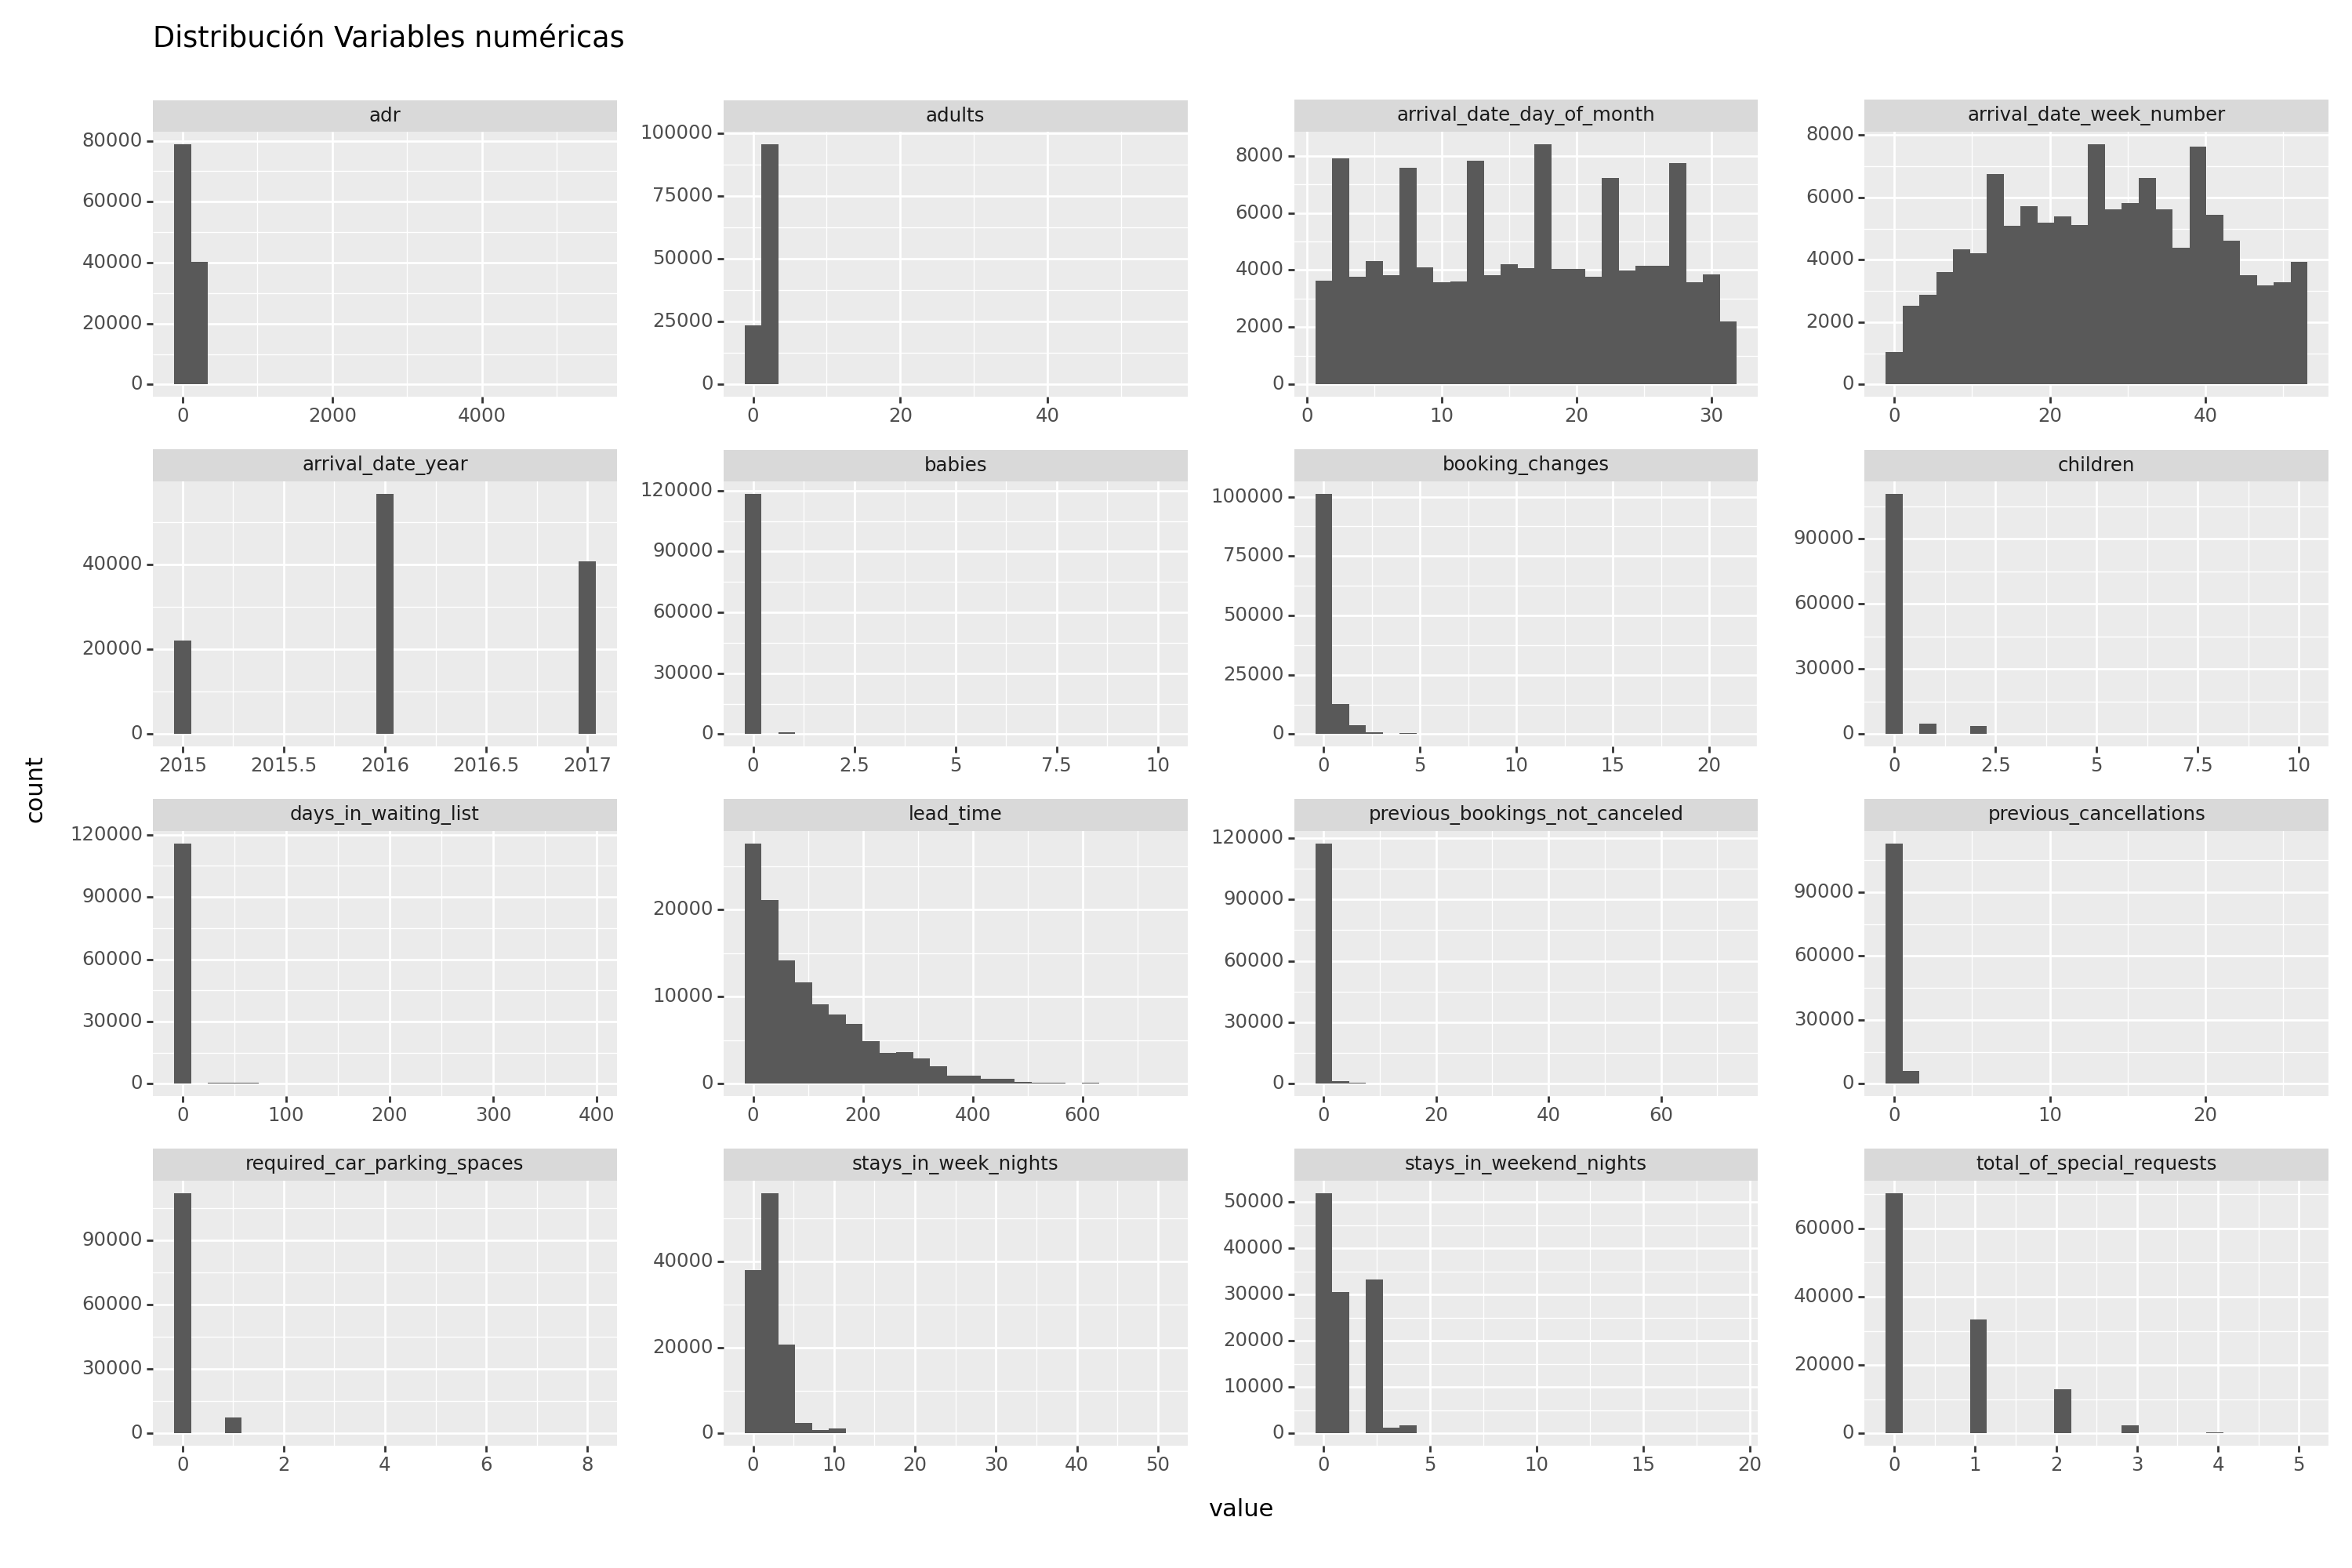

<Figure Size: (1500 x 1000)>

In [ ]:
#********************************** Distribución de variables numéricas

# Se realiza el histograma de variables numéricas

df_numeric=data_hotel_prep.drop(cat_vars,axis=1).melt() #Se almacena un dataframe con la información numérica

#Se realiza histograma sobre las variables

ggp_hist=(ggplot(df_numeric,aes(x="value"))) + geom_histogram(bins=25) + facet_wrap('~variable', scales = 'free') + labs(title="Distribución Variables numéricas")  + theme(subplots_adjust={'hspace': 0.7, 'wspace': 0.7},figure_size=(15,10))
ggp_hist


### Relaciones entre variables

Se muestra la relación entre algunas variables y las cancelaciones por parte de los clientes. Específicamente se muestra la relación frente a

* País: Portugal aportó la mayor cantidad de cancelaciones. Esto era de esperar porque también aporta la mayor cantidad de viajeros. Los demás países aportan alrededor de un 5% de las cancelaciones.

* Tipo de depósito: Existe una muy fuerte tendencia entre las cancelaciones y los clientes que dieron depósito. En general, estos fueron los que aportaron en mayor medida a las cancelaciones

<Axes: xlabel='country'>

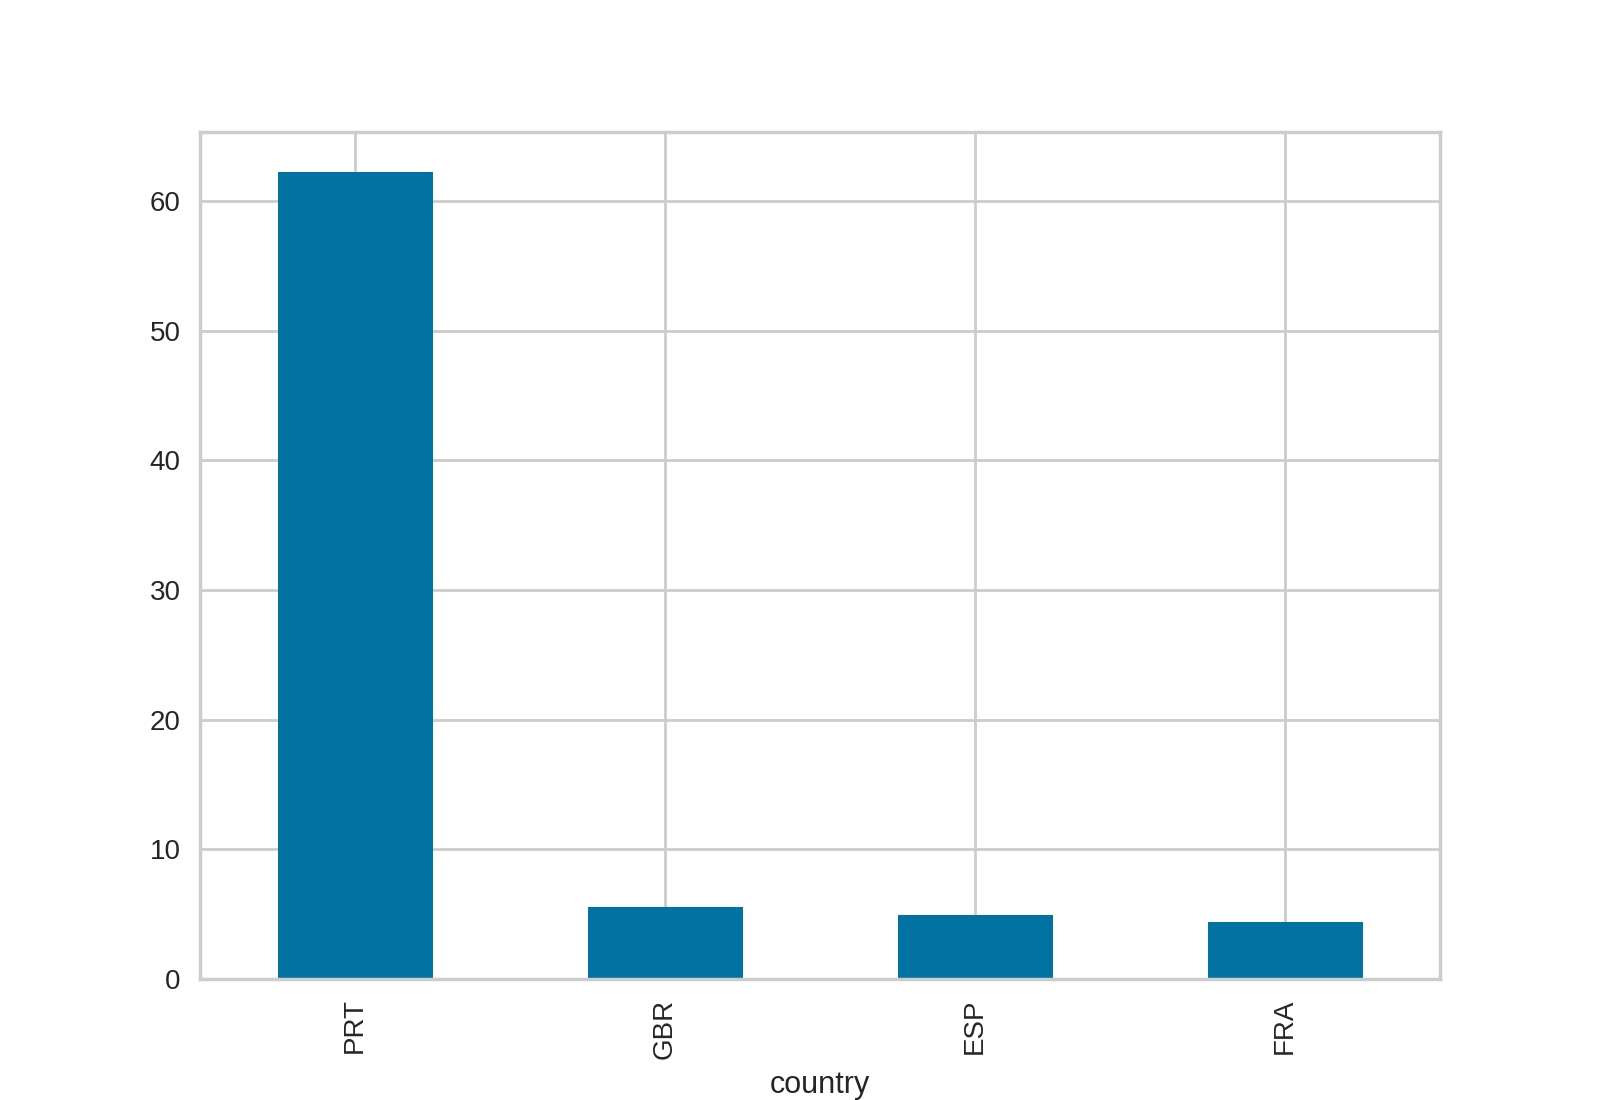

In [ ]:
#*******************************Relación con país.
#Se calcula el aporte de cancelaciones por cada país
canceled_country=data_hotel_prep[["country","is_canceled"]].groupby("country").sum().sort_values(by="is_canceled",ascending=False)*100/data_hotel_prep["is_canceled"].sum()

#Se almacenan aquellos que en total aportaron un 80% de las cancelaciones
canceled_country=canceled_country.loc[canceled_country.cumsum().values <= 80,["is_canceled"]]
canceled_country["is_canceled"].plot.bar() #Se grafica el resultado


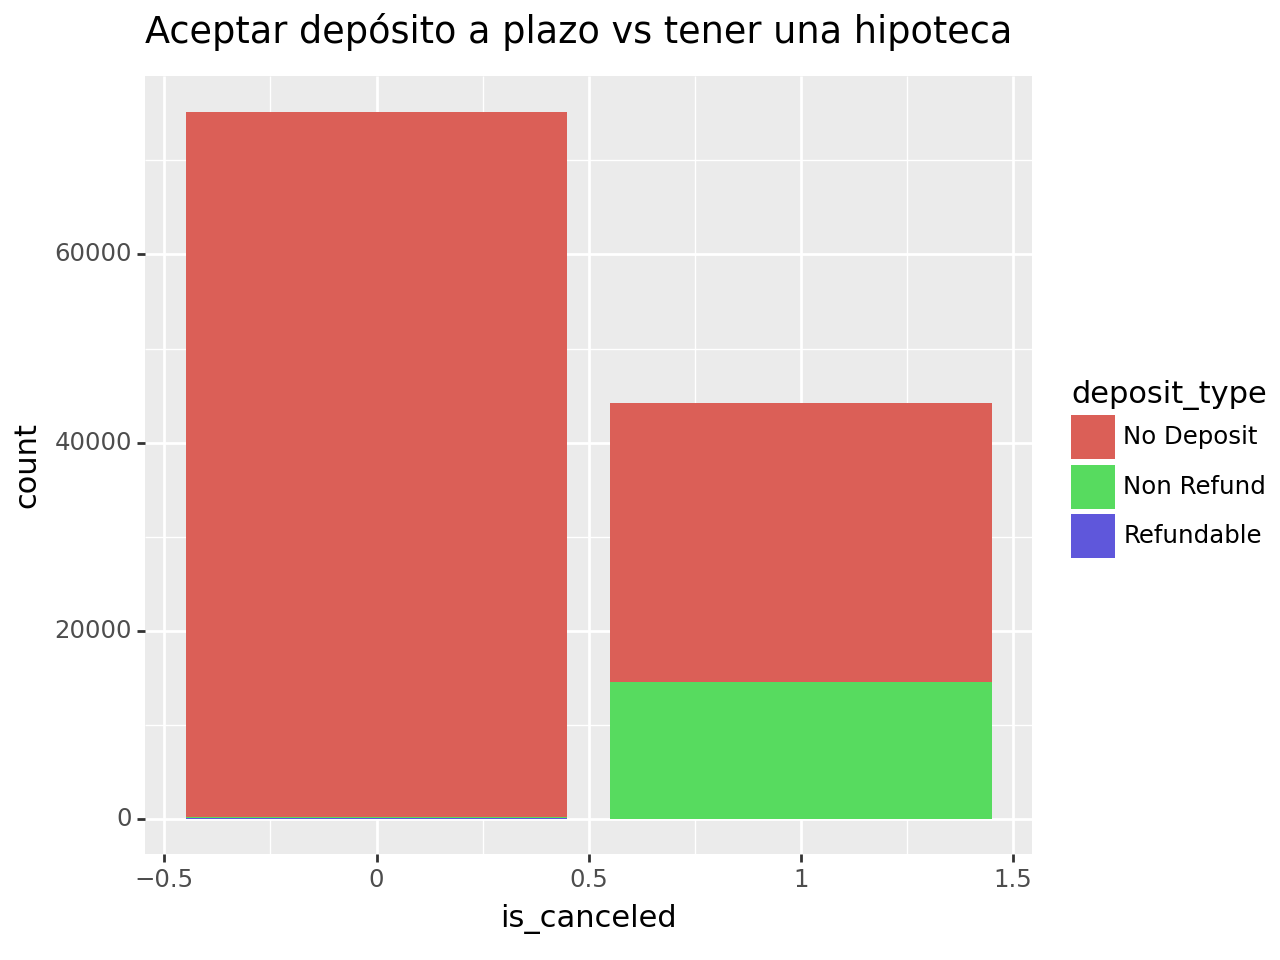

<Figure Size: (640 x 480)>

In [ ]:
#******************************* Relación con tipo de depósito
(
    ggplot(data_hotel_prep[["deposit_type","is_canceled"]].assign(count = 1), aes( x = 'is_canceled', y = 'count', fill = 'deposit_type')) +
    geom_col() +
    labs(title = "Aceptar depósito a plazo vs tener una hipoteca")
)


## Desbalance en las clases

Se grafica el desbalance de clases. Se encuentra un desbalance en clases de 63% (no cancelaron) vs 37% (si cancelaron)


 Distribución de clases: 
 0    62.96
1    37.04
Name: is_canceled, dtype: float64 



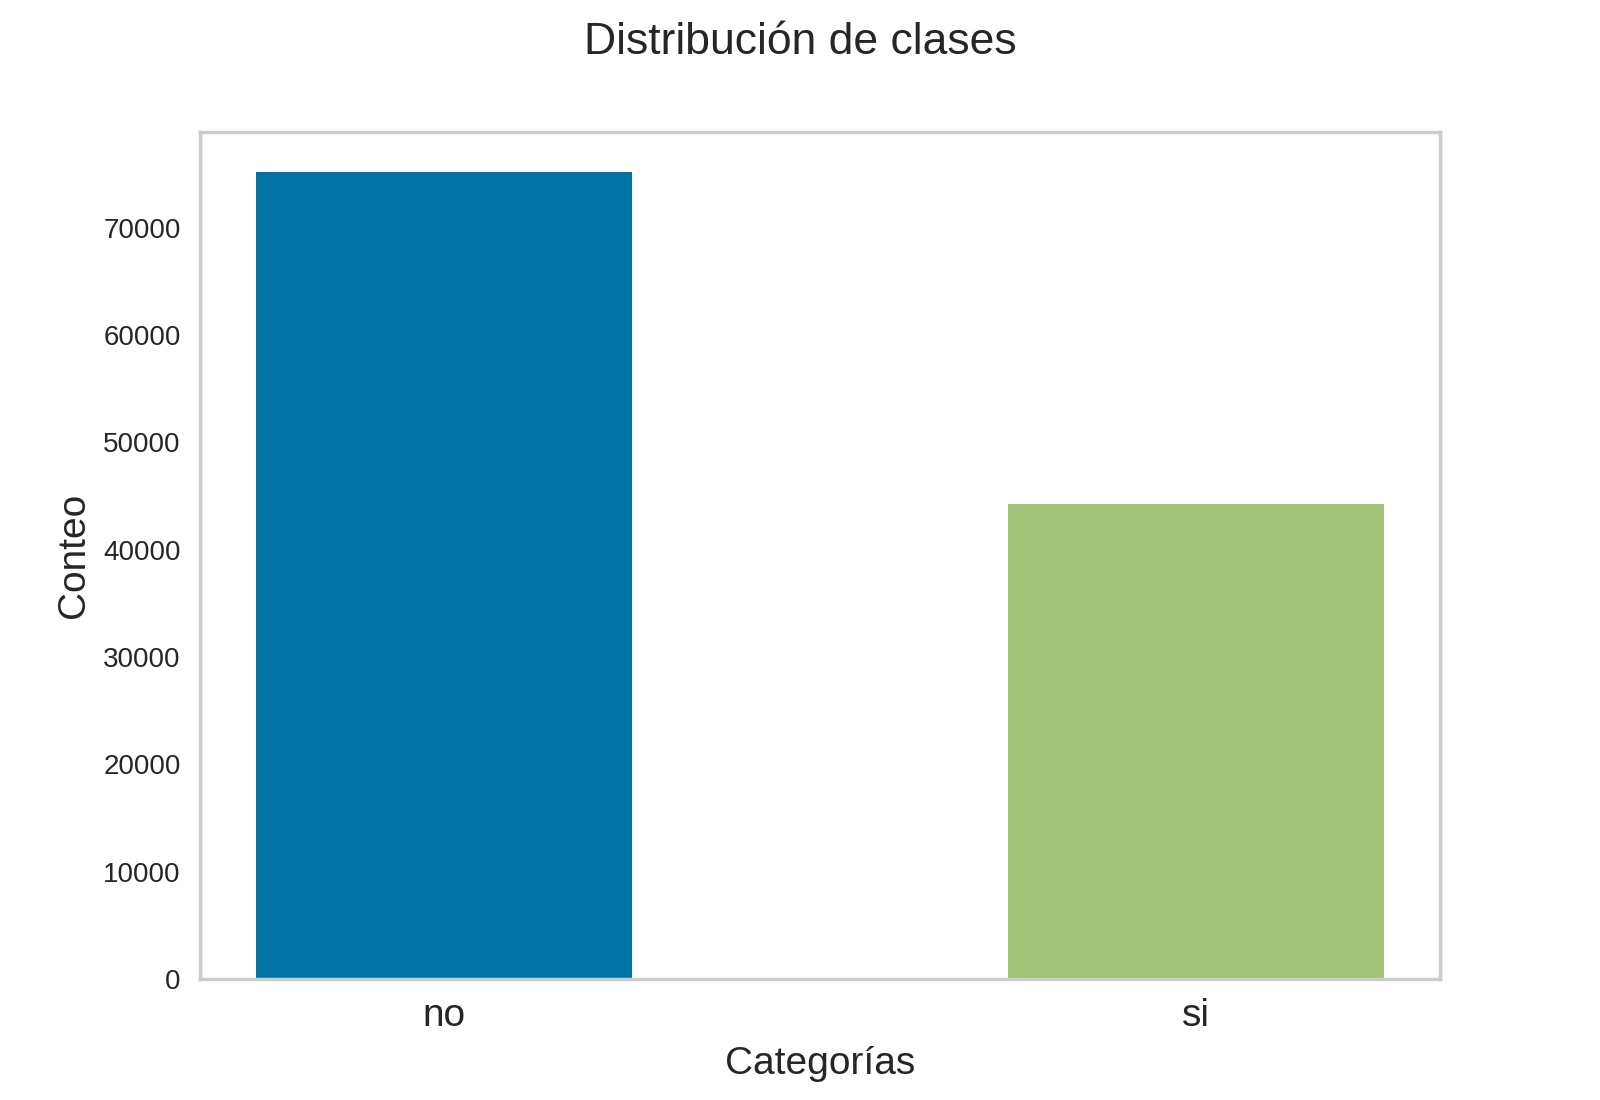

In [ ]:
unbalance=np.round(data_hotel_prep["is_canceled"].value_counts()*100/data_hotel_prep.shape[0],2)
print(f"\n Distribución de clases: \n {unbalance} \n")
fig,ax=plt.subplots()

visualizer=ClassBalance(labels=data_hotel_prep["is_canceled"].unique(),ax=ax)
visualizer.fit(data_hotel_prep["is_canceled"])
ax.set_xticks([0,1])
ax.set_xticklabels(["no","si"],fontsize=14)
ax.set_ylabel("Conteo",fontsize=14)
ax.set_xlabel("Categorías",fontsize=14)
plt.suptitle("Distribución de clases",fontsize=16)
plt.grid(False)



#2) Construir un conjunto de entrenamiento y prueba

1. Escoge una estrategia para construir un conjunto de entrenamiento y prueba.
2. Estratifica los conjuntos por la variable dependiente.

#Solución propuesta
Aprovechando la cantidad de datos, se opta por una estrategia 50-25-25. Como se solicita, los conjuntos se generan de forma estratificada

Tamaños set de entrenamiento ((59695, 31), (59695,)) 
 Tamaños de validación ((29848, 31), (29848,)) 
 Tamaños de prueba ((29847, 31), (29847,))


Text(0.5, 0.98, 'Distribución de los conjuntos estratíficados')

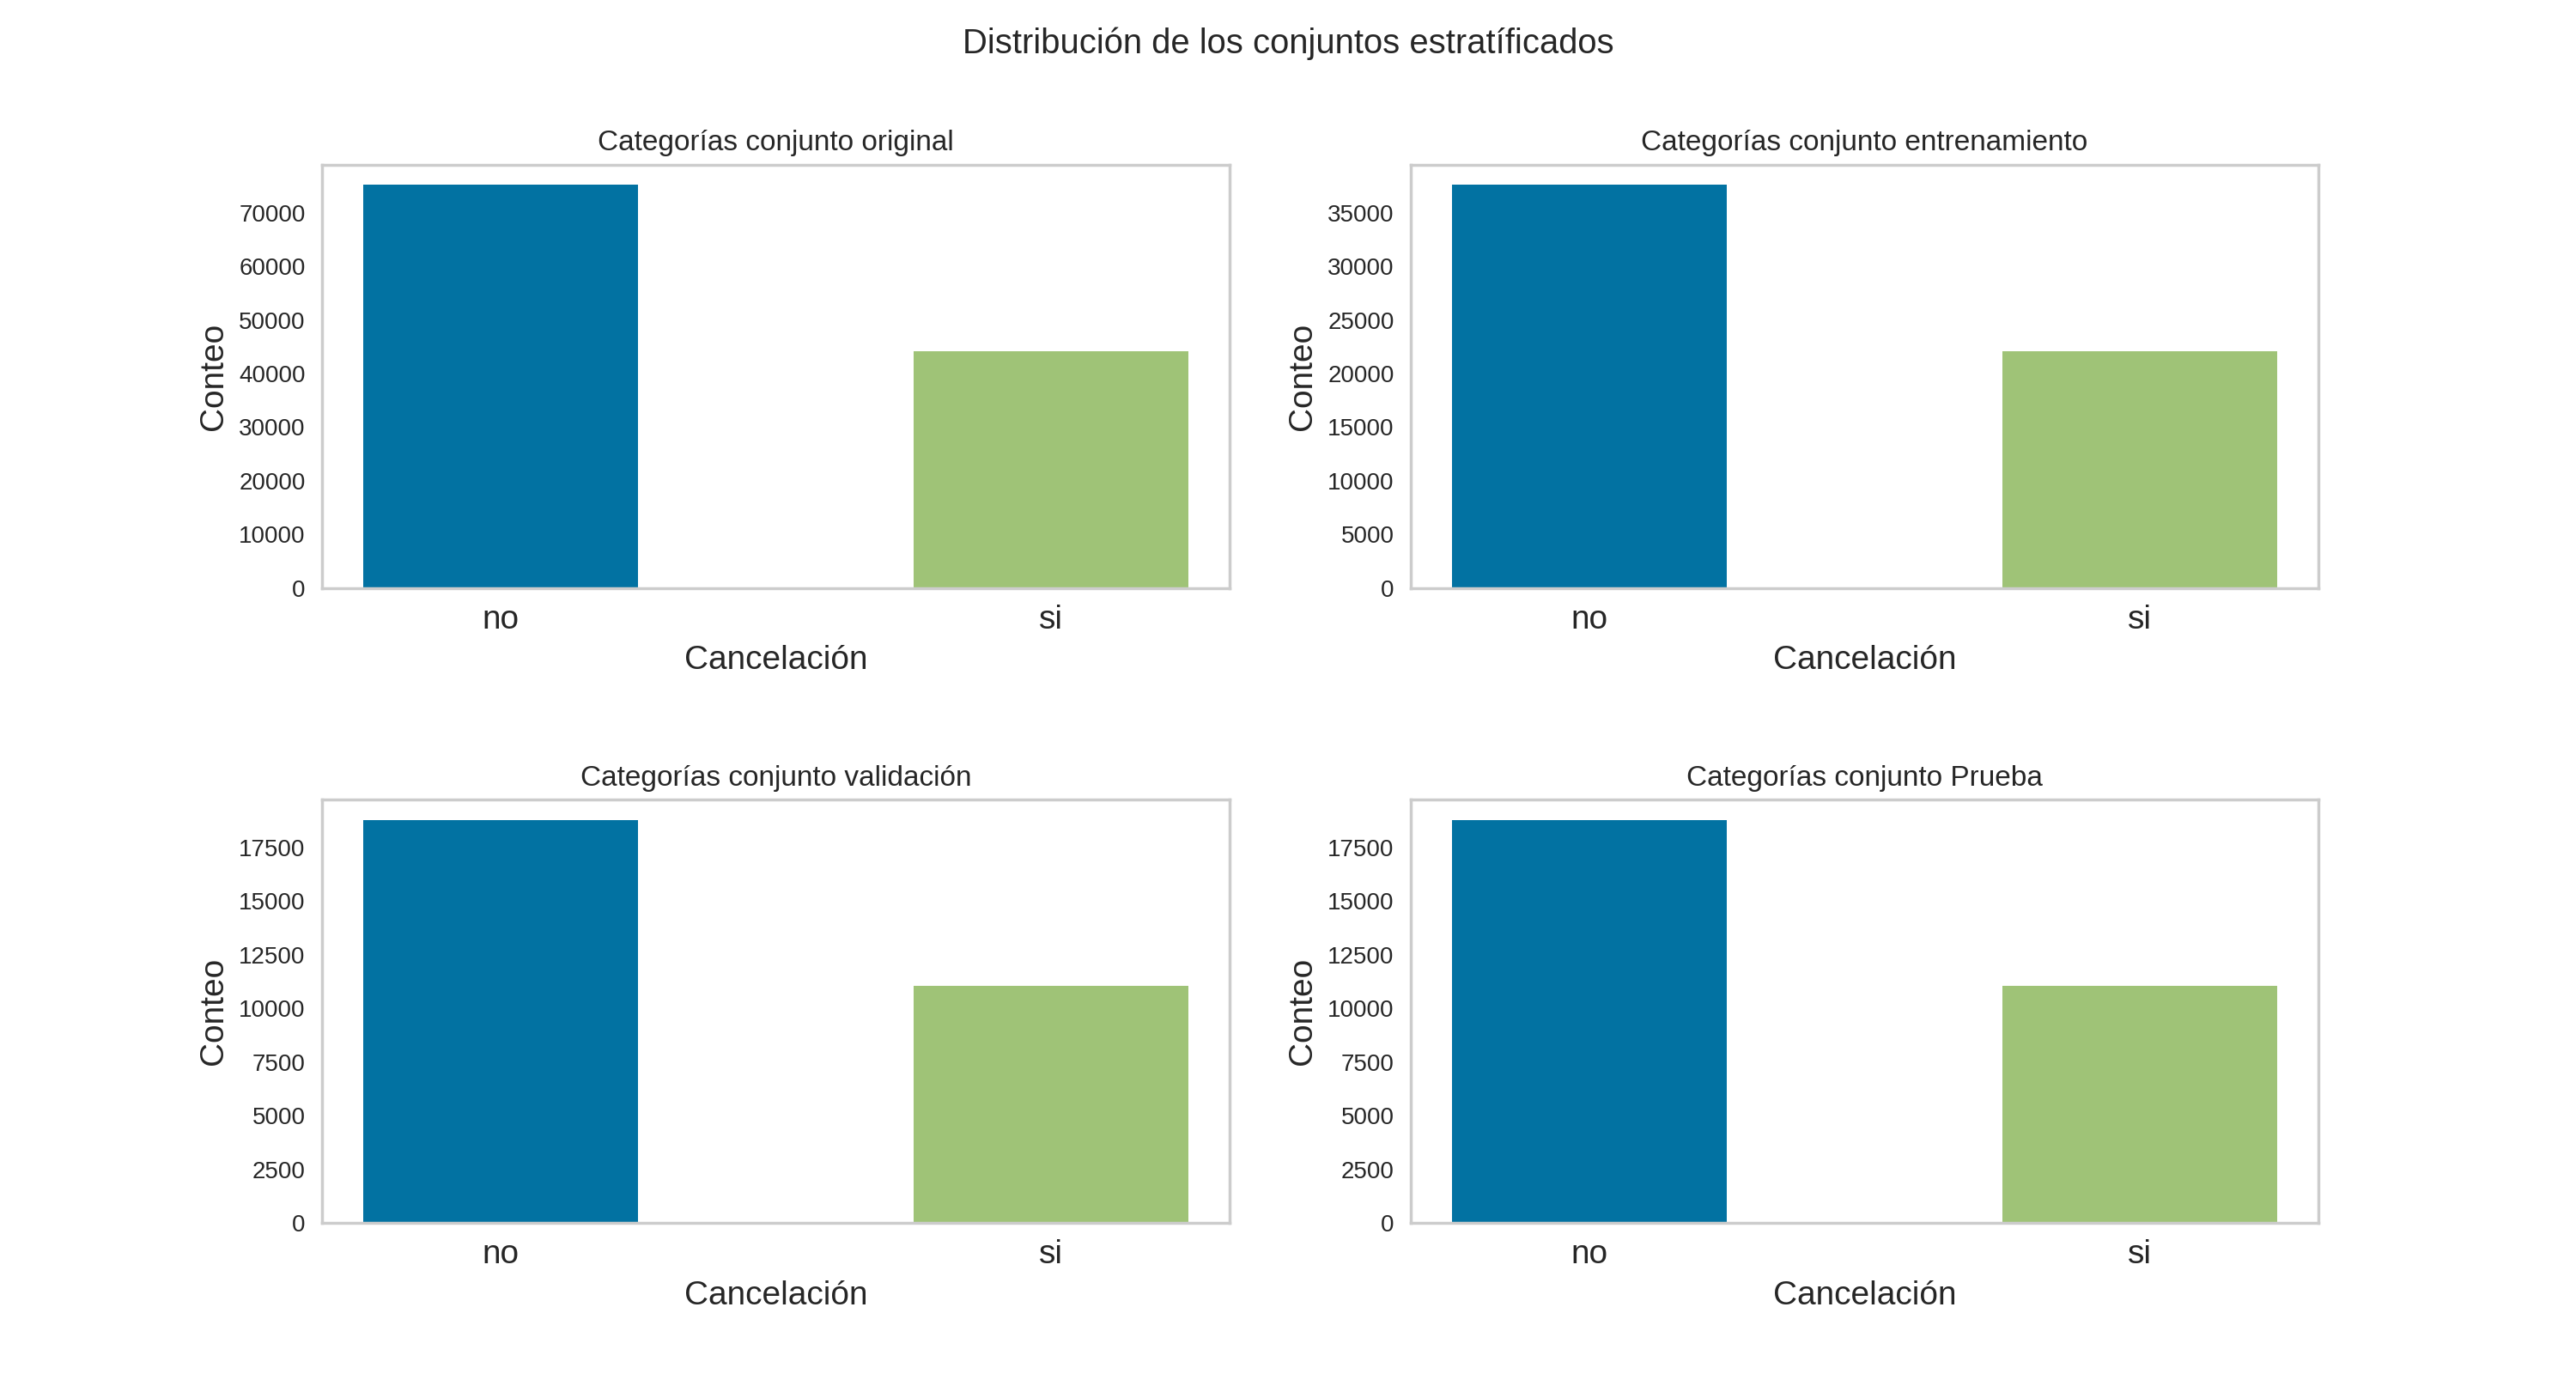

In [ ]:
#********************* Toma de variables dependientes e independientes
X_data_full=data_hotel_prep.drop(["is_canceled"],axis=1)  #Se toman las variables independientes
Y_data_full=data_hotel_prep["is_canceled"] #Se toma la variable dependiente


#********************* Separación set de prueba
seed=42 #Para reproducibilidad
X_Train,X_Validation_and_Test,Y_Train,Y_Validation_and_Test=train_test_split(X_data_full,Y_data_full,
                                                                             train_size=0.5, #Se toma el 50% para entrenamiento
                                                                             random_state=seed, #Reproducibilidad
                                                                             stratify=Y_data_full #Estratificación
                                                                             )

X_Test,X_Validation,Y_Test,Y_Validation=train_test_split(X_Validation_and_Test,Y_Validation_and_Test,
                                                         test_size=0.5, #Se toma el 50% para entrenamiento
                                                         random_state=seed, #Reproducibilidad
                                                         stratify=Y_Validation_and_Test #Estratificación
                                                         )

#********************* Verificación de tamaños
print(f"Tamaños set de entrenamiento {X_Train.shape,Y_Train.shape} \n Tamaños de validación {X_Validation.shape,Y_Validation.shape} \n Tamaños de prueba {X_Test.shape,Y_Test.shape}")

#********************* Se verifica el resultado de la estratificación mediante gráficos de barras

#********* Conjunto original de datos
fig=plt.figure(figsize=(15,8))
ax1=fig.add_subplot(221)
vis1=ClassBalance(labels=[0,1],ax=ax1);
vis1.fit(data_hotel_prep["is_canceled"]);
ax1.set_xticks([0,1])
ax1.set_xticklabels(["no","si"],fontsize=14)
ax1.set_ylabel("Conteo",fontsize=14)
ax1.set_xlabel("Cancelación",fontsize=14)
ax1.set_title("Categorías conjunto original")
ax1.grid(False)

#********* Conjunto de entrenamiento
ax2=fig.add_subplot(222)
vis2=ClassBalance(labels=[0,1],ax=ax2);
vis2.fit(Y_Train);
ax2.set_xticks([0,1])
ax2.set_xticklabels(["no","si"],fontsize=14)
ax2.set_ylabel("Conteo",fontsize=14)
ax2.set_xlabel("Cancelación",fontsize=14)
ax2.set_title("Categorías conjunto entrenamiento")
ax2.grid(False)

#********* Conjunto de validación
ax3=fig.add_subplot(223)
vis3=ClassBalance(labels=[0,1],ax=ax3);
vis3.fit(Y_Validation);
ax3.set_xticks([0,1])
ax3.set_xticklabels(["no","si"],fontsize=14)
ax3.set_ylabel("Conteo",fontsize=14)
ax3.set_xlabel("Cancelación",fontsize=14)
ax3.set_title("Categorías conjunto validación")
ax3.grid(False)

#********* Conjunto de prueba
ax4=fig.add_subplot(224)
vis4=ClassBalance(labels=[0,1],ax=ax4);
vis4.fit(Y_Test);
ax4.set_xticks([0,1])
ax4.set_xticklabels(["no","si"],fontsize=14)
ax4.set_ylabel("Conteo",fontsize=14)
ax4.set_xlabel("Cancelación",fontsize=14)
ax4.set_title("Categorías conjunto Prueba")
ax4.grid(False)

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribución de los conjuntos estratíficados")


#3) Reportar el error de clasificación el conjunto de prueba

Con un modelo base. Utilizando el conjunto de prueba:
1. Reporta el error de clasificación F1.
2. Grafica e interpreta la matriz de confusión.
3. Grafica e interpreta reporte de clasificación de precisión, recall y F1 score.
4. Grafica e interpreta la curva ROC y el AUC score.

#Conclusiones del punto

Se escoge como modelo inicial un árbol de decisión con profundidad máxima de 4. Tras ajustar el modelo sobre el set de entrenamiento,y validar sobre el set de prueba, se encontraron los siguientes puntos:

* Se obtiene un score de validación cruzada de 0.84 sobre set de entrenamiento, 0.74, y 0.75 sobre sets de validación y prueba respectivamente.
* De la matriz de confusión se puede observar que el modelo es mejor prediciendo cuando un cliente no cancela su reserva. Esto era de esperarse ya que es la clase dominante. También se encuentra que los errores del modelo se concentral en la categoria de falsos positivos, es decir, predice que se cancela cuando en realidad no se cancela.

En cuanto al reporte de clasificación

* Se encuentra una precisión de 0.92 sobre la clase "No canceló", es decir que  el modelo acertó en el 92% de los casos en los cuales predijo que el cliente no cancelaría.
* Se encuentra un recall de 0.52 sobre la clase "No canceló", es decir que el modelo pudo identificar de forma adecuada el 52% de los clientes que no cancelarían.
* El f1 sobre la clase "No canceló" armoniza los anteriores puntajes.

* Se encuentra una precisión de 0.56 sobre la clase "Sí canceló", es decir que  el modelo acertó en el 56% de los casos en los cuales predijo que el cliente no cancelaría.
* Se encuentra un recall de 0.92 sobre la clase "Sí canceló", es decir que el modelo pudo identificar de forma adecuada el 92% de los clientes que no cancelarían. Este índice es bajo debido a que el modelo genera muchos falsos positivos.
* El f1 sobre la clase "Sí canceló" armoniza los anteriores puntajes.

* En la curva ROC-AUC Se evidencia una curva de codo, a partir de la cual, la relación entre verdaderos positivos, y falsos positivos es prácticamente lineal. Esto quiere decir que para el modelo incial, aumentar el recall sobre la clase que Cancela sus reservaciones, implica un aumento proporcional sobre los errores que comete el modelo.

En general, los puntajes del reporte de clasificación se ven muy afectados por la alta cantidad de falsas cancelaciones predecidas por el modelo.


### Transformación de variables

Antes de entrar a la fase de modelado, se realiza el tratamiento de las variables del ejercicio para que sean aptas para el modelo. Esto se consigue de la siguiente manera

### Tratamiento de variables cuantitativas

Se aplica transformación logarítmica sobre variables cuantitativas para acercar más su distribución a un comportamiento normal.


### Tratamiento de variables categóricas

Se da el siguiente tratamiento a las variables categóricas de acuerdo con su naturaleza. Dependiendo de si son ordinales o nominales se usa one-hot-encoding u ordinal encoding. También se eliminan variables redundantes o que generan data leakage.

El tratamiento dado a cada variable se describe dentro de las funciones preprocesing_categorical, y preprocesing_numerical




In [ ]:
#**************************************************************** Definición de funciones ********************************************************************************

def preprocesing_categorical(X_data):
    ''' Descripción:
            Función encargada de realizar el preprocesamiento de las variables independientes

            Se utiliza One Hot Encoder para las siguientes variables:
              * hotel
              * market_segment
              * deposit_type
              * customer_type
              * Country: Del análisis exploratorio se identificó que PRT, GBR, ESP, FRA, aportan el 80% de las cancelaciones. Se mantienen segregados estos países.
                         Los demás países se agrupan en "Other"

            Se utiliza ordinal Encoder para las siguientes variables:
              * reserved_room_type
              * arrival_date_month
              * assigned_room_type (Se mantiene porque puede llegar una relación entre cambio de cuarto reservado y cancelaciones)


            Se desprecian variables con información redundante, o innecesaria de cara a la posibilidad de cancelación. También variables que pueden ocasionar data leakage
              * meal: Se asume que no es información relevante para la cancelación.
              * Distribution: Información redundante de la variable market_segment
              * reservation_status: Redundante con la variable is_canceled. Genera además data Leakage
              * reservation_status_date: Variable que sólo se tiene una vez el cliente tomó acción de cancelar, checkout, o no presentarse. No se tiene al momento de realizar una predicción (Data leakage)

            Las siguientes variables se mantienen invariables, ya que en escencia son categóricas por tratarse de un ID
              * company
              * agent

        Inputs:
            * X_data: Conjunto de variables independientes

        Return:
            * data_categorical: Dataframe con información categorica concatenada de acuerdo a lo mencionado en la descripción

    '''

    #********************** Variables con One Hot Encoder
    data_ohe=X_data[["hotel","market_segment","deposit_type","customer_type","country"]].copy() #Copia del dataframe original
    data_ohe.loc[~ data_ohe["country"].isin(["PRT", "GBR", "ESP", "FRA"]) ,"country"]="Other" #Se reasigna la información de países
    data_ohe=pd.get_dummies(data_ohe,columns=data_ohe.columns,prefix="Class_") #Se usa la función Get dummies de Pandas para generar One Hot Encoder

    #********************** Variables con ordinal encoder
    data_ord=X_data[["reserved_room_type","arrival_date_month","assigned_room_type"]].copy() #Copia del dataframe original

    months=["January",	"February",	"March",	"April",	"May",	"June",	"July",	"August",	"September",	"October",	"November", "December"] #Orden asignado a los meses
    data_ord["arrival_date_month"]=OrdinalEncoder(categories=[months]).fit_transform(data_ord[["arrival_date_month"]])+1 #Conversion One Hot

    room_type=["A",	"B",	"C",	"D",	"E",	"F",	"G",	"H",	"I",	"K",	"L", "P"] #Orden asignado a los cuartos
    data_ord["reserved_room_type"]=OrdinalEncoder(categories=[room_type]).fit_transform(data_ord[["reserved_room_type"]]) #Conversiones one hot
    data_ord["assigned_room_type"]=OrdinalEncoder(categories=[room_type]).fit_transform(data_ord[["assigned_room_type"]])

    data_categorical=pd.concat([data_ohe,data_ord,X_data[["company","agent"]]],axis=1) #Concatenado de las variables categóricas

    #Se elimina la columna Class_Undefined, que hace parte de market_segment, pero que tiene únicamente dos observaciones.
    #Esto generaría problemas ya que tenemos partición en tres grupos, y únicamente dos registros "Undefined"
    #No se pierde información ya que se entiende que si las demás variables dummy de la clase son 0, entonces se trata de un registro "Undefined"

    if "Class__Undefined" in data_categorical.columns:
        data_categorical.drop(["Class__Undefined"],axis=1,inplace=True)

    return data_categorical

def preprocesing_numerical(X_data,cat_vars):
    '''
    Descripción:
        Función encargada de realizar el preprocesamiento de las variables cuantitativas
        Se aplica transformación de logaritmo para aproximar más a comportamiento de campana

        Se eliminan variables que no aportan al entrenamiento del modelo
        * arrival_date_year: No sirve para predecir qué ocurriría con el año de llegada de nuevos clientes.
        * arrival_date_day_of_month: Puede ser redundante con la información de arrival_date_week_number y arrival_date_month

        Se eliminan variables causantes de data leakage

    Inputs:
        * X_data: DataFrame con información variables independientes
        * cat_vars: Conjunto de variables categóricas (Usadas para determinar las variables numéricas)

    Return:
        * data_numerical: DataFrame con información numerica procesada

    '''
    cat_vars_clean=cat_vars.copy() #Se toma una copia de la lista de variables categóricas
    cat_vars_clean.remove("is_canceled") #de la lista de variables categóricas se elimina la variable de salida que se tenía anteriormente
    data_numerical=X_data.drop(cat_vars_clean,axis=1).copy()

    for column in data_numerical.columns:
        data_numerical[column]=np.log(data_numerical[column]+1+np.abs(np.min(data_numerical[column]))) #Se hace conversión logarítmica garantizando datos positivos

    return data_numerical

def data_prep(X_data,cat_vars):
    '''Descripción:
          Función encargada de concatenar los dataframes resultantes del preprocesamiento de variables numéricas y categóricas

       Inputs:
          * X_data: DataFrame con información de variables independientes
          * cat_vars: Lista de variables categóricas

       Return
          * X_data_prep: Dataframe con variables independientes preprocesadas
    '''
    data_numerical= preprocesing_numerical(X_data,cat_vars)
    data_categorical= preprocesing_categorical(X_data)
    return pd.concat([data_numerical,data_categorical],axis=1)

#*************************************************************************************************************************************************************

#Se preprocesa la data de las variables independientes con las funciones generadas

X_Train_prep=data_prep(X_Train,cat_vars)
X_Val_prep=data_prep(X_Validation,cat_vars)
X_Test_prep=data_prep(X_Test,cat_vars)



### Elaboración de funcione para modelado y evaluación de calidad

A continuación se elaboran funciones de evaluación y reporte de calidad del modelo. Se presentan las funciones.

* score_model: Encargada de evaluar el error sobre el set de entrenamiento, validación, y prueba

* Confussion_f1_rocauc: Encargada de presentar la matriz de confusión y reporte f1 a partir de un modelo ajustado sobre un set de datos




 Error promedio de validación cruzada sobre el set de entrenamiento:  0.84

 Error sobre set de validación  0.74

 Error sobre set de Prueba  0.75




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


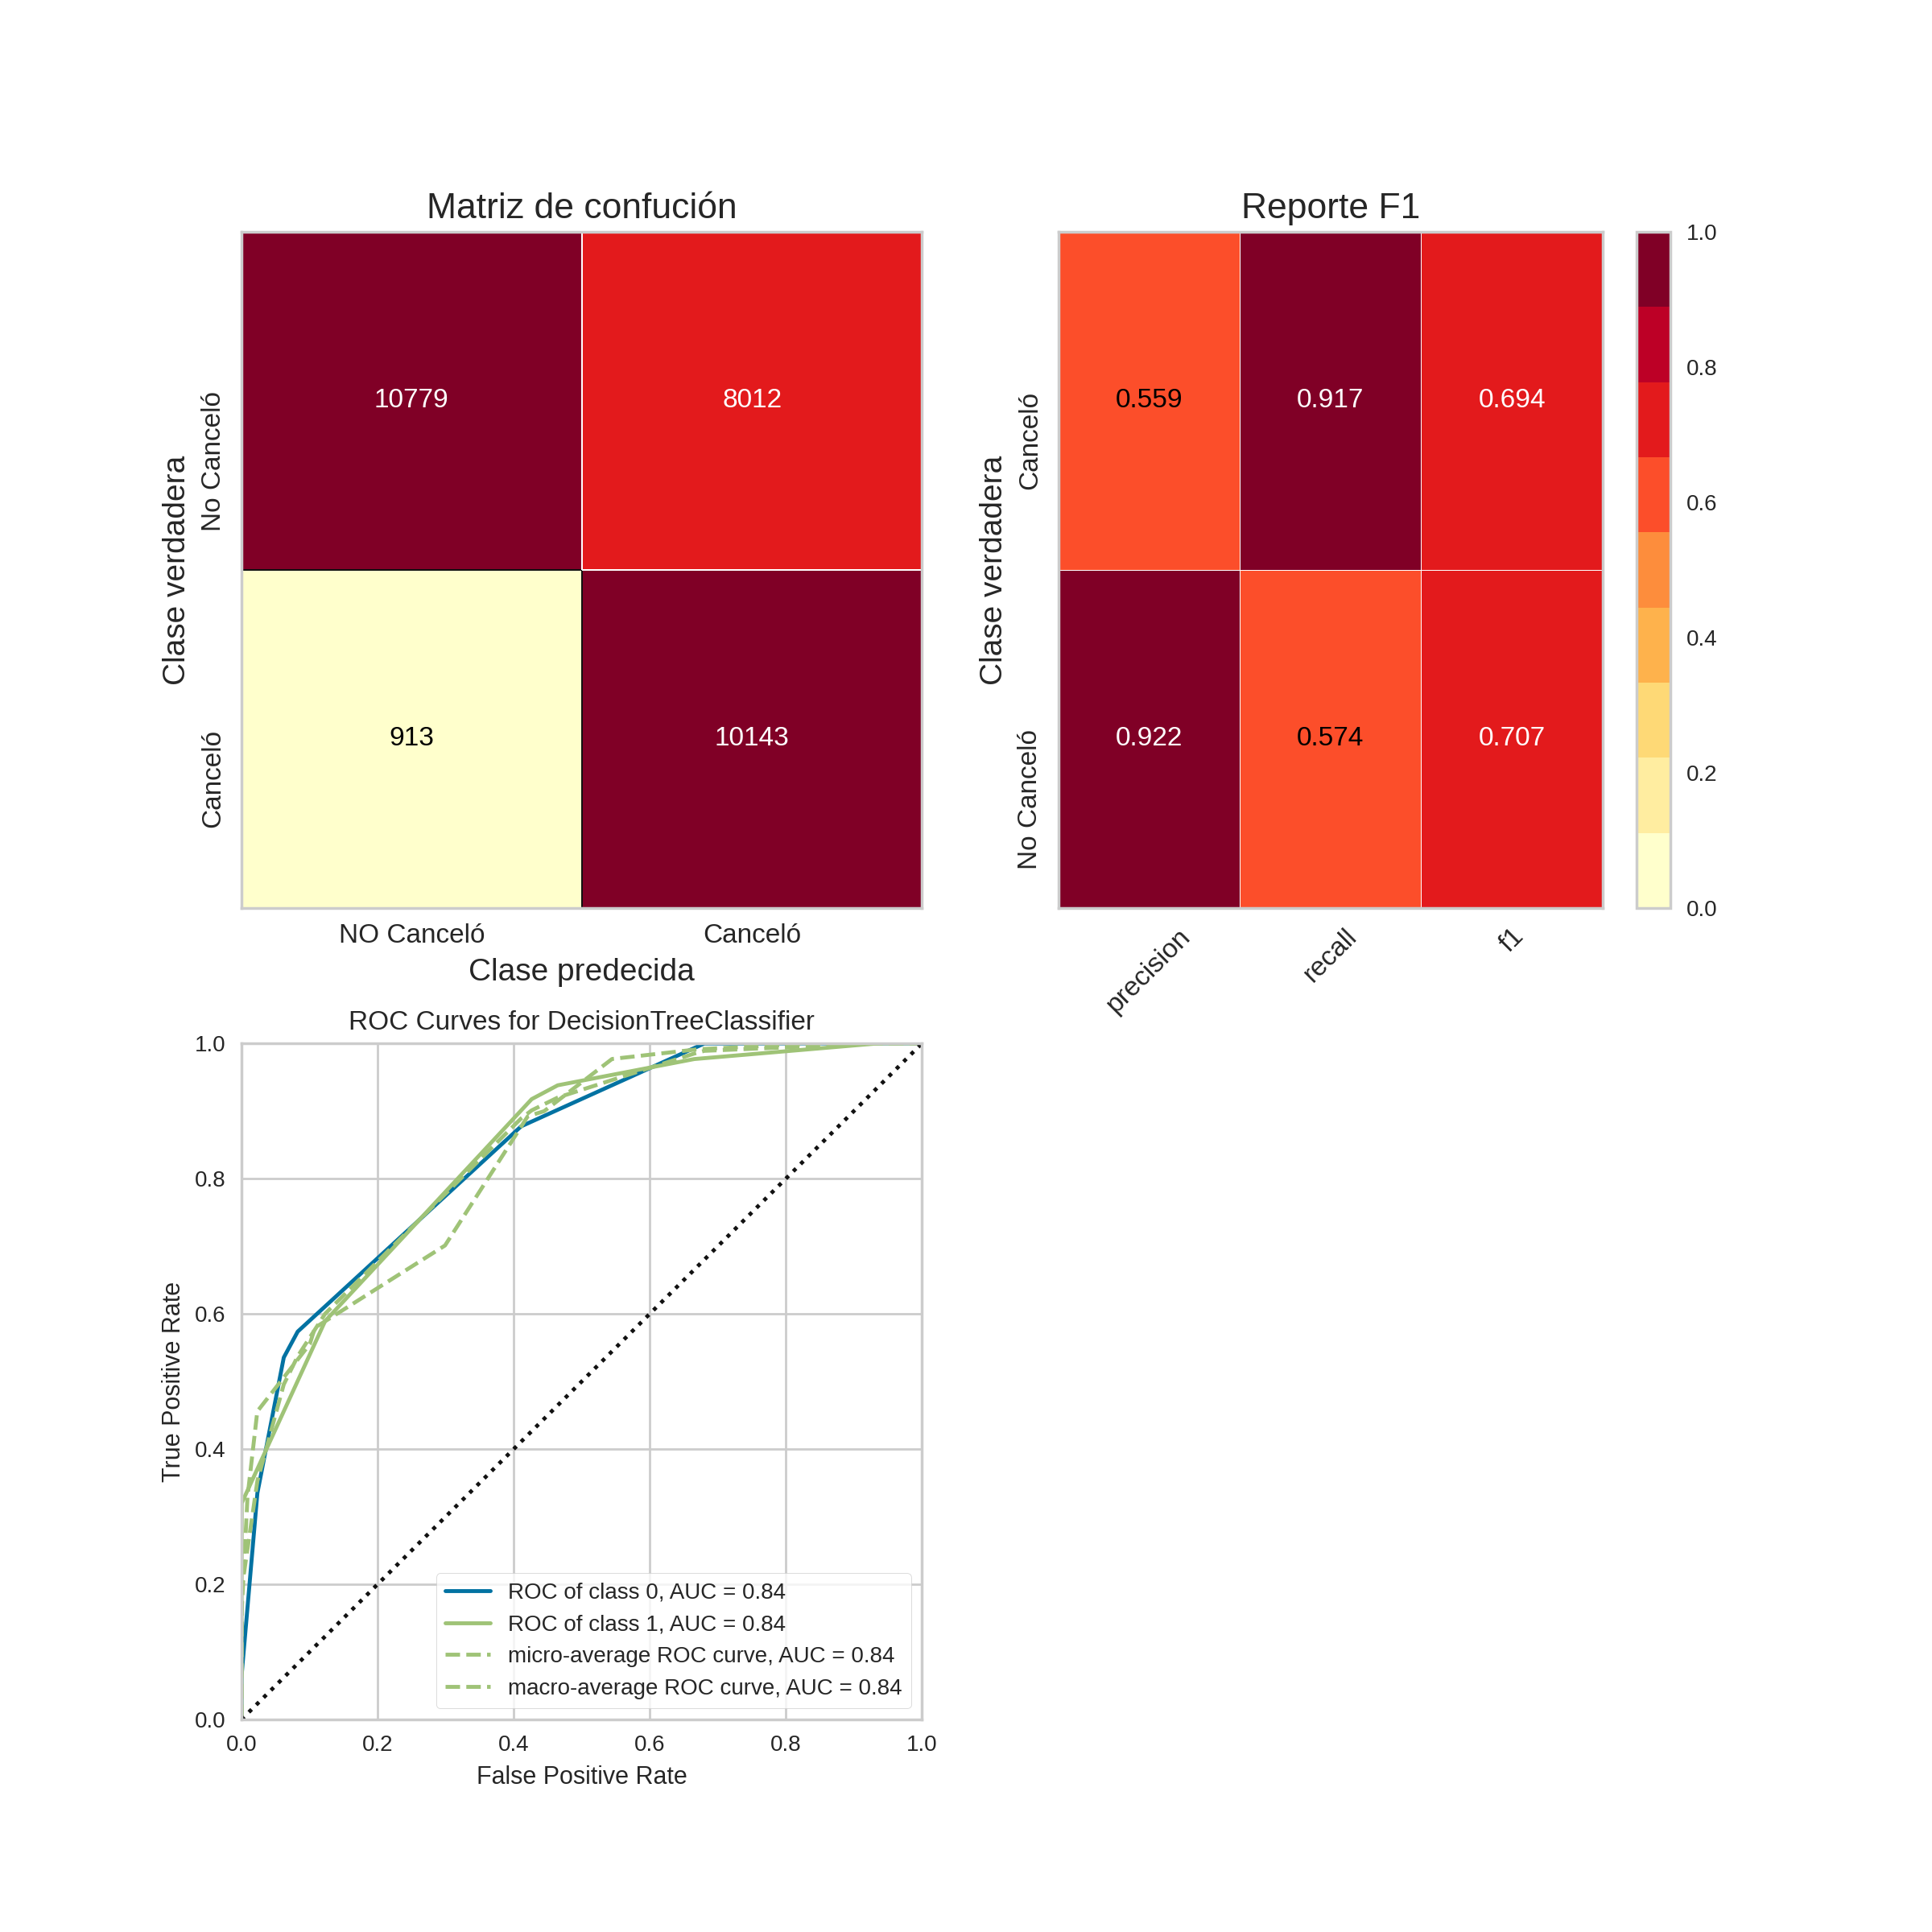

<Figure size 800x550 with 0 Axes>

In [ ]:
#***************************************************** Declaración de funciones *********************************************************
def score_model(X_Train,Y_Train,X_Val,Y_Val,X_Test,Y_Test,model):
    '''
    Descripción:
        Función encargada de evaluar los errores sobre el set de entrenamiento, validación, y prueba
            * Se usa cross-validation para cuantificar error sobre set de entrenamiento
            * Al final de la función se comparan los errores obtenidos
    Inputs:
        * X_Train: Set de entrenamiento variables independientes
        * Y_Train: Set de entrenamiento variable dependiente
        * X_Val:   Set de validación variables independientes
        * Y_Val:   Set de validación variable dependiente
        * X_Test:  Set de prueba variables independientes
        * Y_Test:  Set de prueba variable dependiente

    Return
        None

    '''

    #*************************** Error del set de entrenamiento
    train_score=cross_val_score(model,X_Train,Y_Train,cv=10,scoring="roc_auc") #Validación cruzada sobre set entrenamiento
    print( "\n Error promedio de validación cruzada sobre el set de entrenamiento: ",np.round(np.mean(train_score),2))

    #*************************** Error del set de validación
    val_predict=model.predict(X_Val) #Predicción valores de validación
    val_score=np.round(roc_auc_score(Y_Val,val_predict),2) #Cálculo de error con roc-auc
    print("\n Error sobre set de validación ", val_score)

    #*************************** Error del set de Prueba
    test_predict=model.predict(X_Test) #Predicción valores de validación
    test_score=np.round(roc_auc_score(Y_Test,test_predict),2) #Cálculo de error con roc-auc
    print("\n Error sobre set de Prueba ", test_score)


def Confussion_f1_rocauc(X_Train_data,Y_Train_data,X_Test_data,Y_Test_data,model):
    '''
    Descripción:
        Función encargada de imprimir la matriz de confusión, reporte f1, y curva ROC-AUC a partir de una predicción del modelo model, sobre las variables X_data, Y_data

    Inputs:
        * X_Train_data: Set entrenamiento con variables independientes
        * Y_Train_data: Set entrenamiento con variables dependientes
        * X_Test_data:  Set Prueba con variables independientes
        * Y_Test_data:  Set prueba con variables dependientes
        * model: Modelo ajustado sobre los datos

    '''
    print("\n")
    figure=plt.figure(figsize=(12,12))
    figure.add_subplot(221)
    conf_vis=ConfusionMatrix(model,classes=[0,1])
    conf_vis.fit(X_Train_data,Y_Train_data)
    conf_vis.score(X_Test_data,Y_Test_data)
    plt.title("Matriz de confución",fontsize=16)
    plt.ylabel("Clase verdadera",fontsize=14)
    plt.xlabel("Clase predecida",fontsize=14)
    plt.xticks([0.5,1.5],["NO Canceló","Canceló"],rotation="horizontal")
    plt.yticks([0.5,1.5],["Canceló","No Canceló"],rotation="vertical")

    figure.add_subplot(222)
    f1_vis=ClassificationReport(model,classes=[0,1])
    f1_vis.fit(X_Train_data,Y_Train_data)
    f1_vis.score(X_Test_data,Y_Test_data)
    plt.title("Reporte F1",fontsize=16)
    plt.ylabel("Clase verdadera",fontsize=14)
    plt.yticks([0.5,1.5],["No Canceló","Canceló"],rotation="vertical")

    figure.add_subplot(223)
    roc_vis=ROCAUC(model,classes=[0,1])
    roc_vis.fit(X_Train_data,Y_Train_data)
    roc_vis.score(X_Test_data,Y_Test_data)
    roc_vis.show()


    plt.subplots_adjust(hspace=10,wspace=30)


#***************************************************************************************************************

#******************************************* Se ajusta el modelo inicial sobre el set de datos
dtc_initial=DecisionTreeClassifier(max_depth=4,random_state=seed,class_weight="balanced");
dtc_initial.fit(X_Train_prep,Y_Train)

#******************************************* Cálculo de errores sobre sets, e impresión de matriz de confusión + Reporte f1
score_model(X_Train_prep,Y_Train,X_Val_prep,Y_Validation,X_Test_prep,Y_Test,dtc_initial)
Confussion_f1_rocauc(X_Train_prep,Y_Train,X_Test_prep,Y_Test,dtc_initial)



#4) Producir un modelo que supere el mejor F1-score de tu modelo base

En el conjunto de prueba. Considera las siguientes estrategias vistas en el módulo (no necesitas utilizar todas, solo las que consideres necesarias):
* Escoger un modelo apropiado.
* Escoger la métrica de scoring adecuada como roc_auc_score o f1.
* Escoger los hiperparámetros óptimos del modelo utilizando grid search o random search.
* Escoger el punto de corte de probabilidad adecuado utilizando el método de Discrimination Threshold.
* Ingeniería de variables: transformaciones y/o crear nuevas variables.
* Seleccionar variables: matriz de correlaciones, REFCV, quitar y poner.

#Conclusiones del punto

Se busca modificar el modelo a partir de tres procedimientos principales

* Búsqueda de hiperparámetros: Se define un rango apropiado de búsqueda para los hipérparámetros "max_depth", y "min_samples_leaf". Mediante un grid search se escojen los valores de max_depth=10 y min_sample_leaf=150. Se consigue mejorar scoring de validación de 0.75 a 0.82 y de prueba de 0.75 a 0.82.

* Eliminación recursiva de parámetros: Se usa la herramienta  de yellowbrick para reducir la dimensionalidad del set de datos. Se transforma el set de 42 variables a 11. No se encuentran modificaciones significativas sobre el scoring de validación o prueba, pero se elige seguir con el modelo que requiere menos variables para su entrenamiento y predicción.

* Moddificación del threshold de discriminación: A partir de la curva de discriminación del threshold, y la curva de precision vs recall, se decide no modificar el umbral de clasificación, principalmente porque no se evidencia de primera vista una mejora significativa por modificar este criterio.

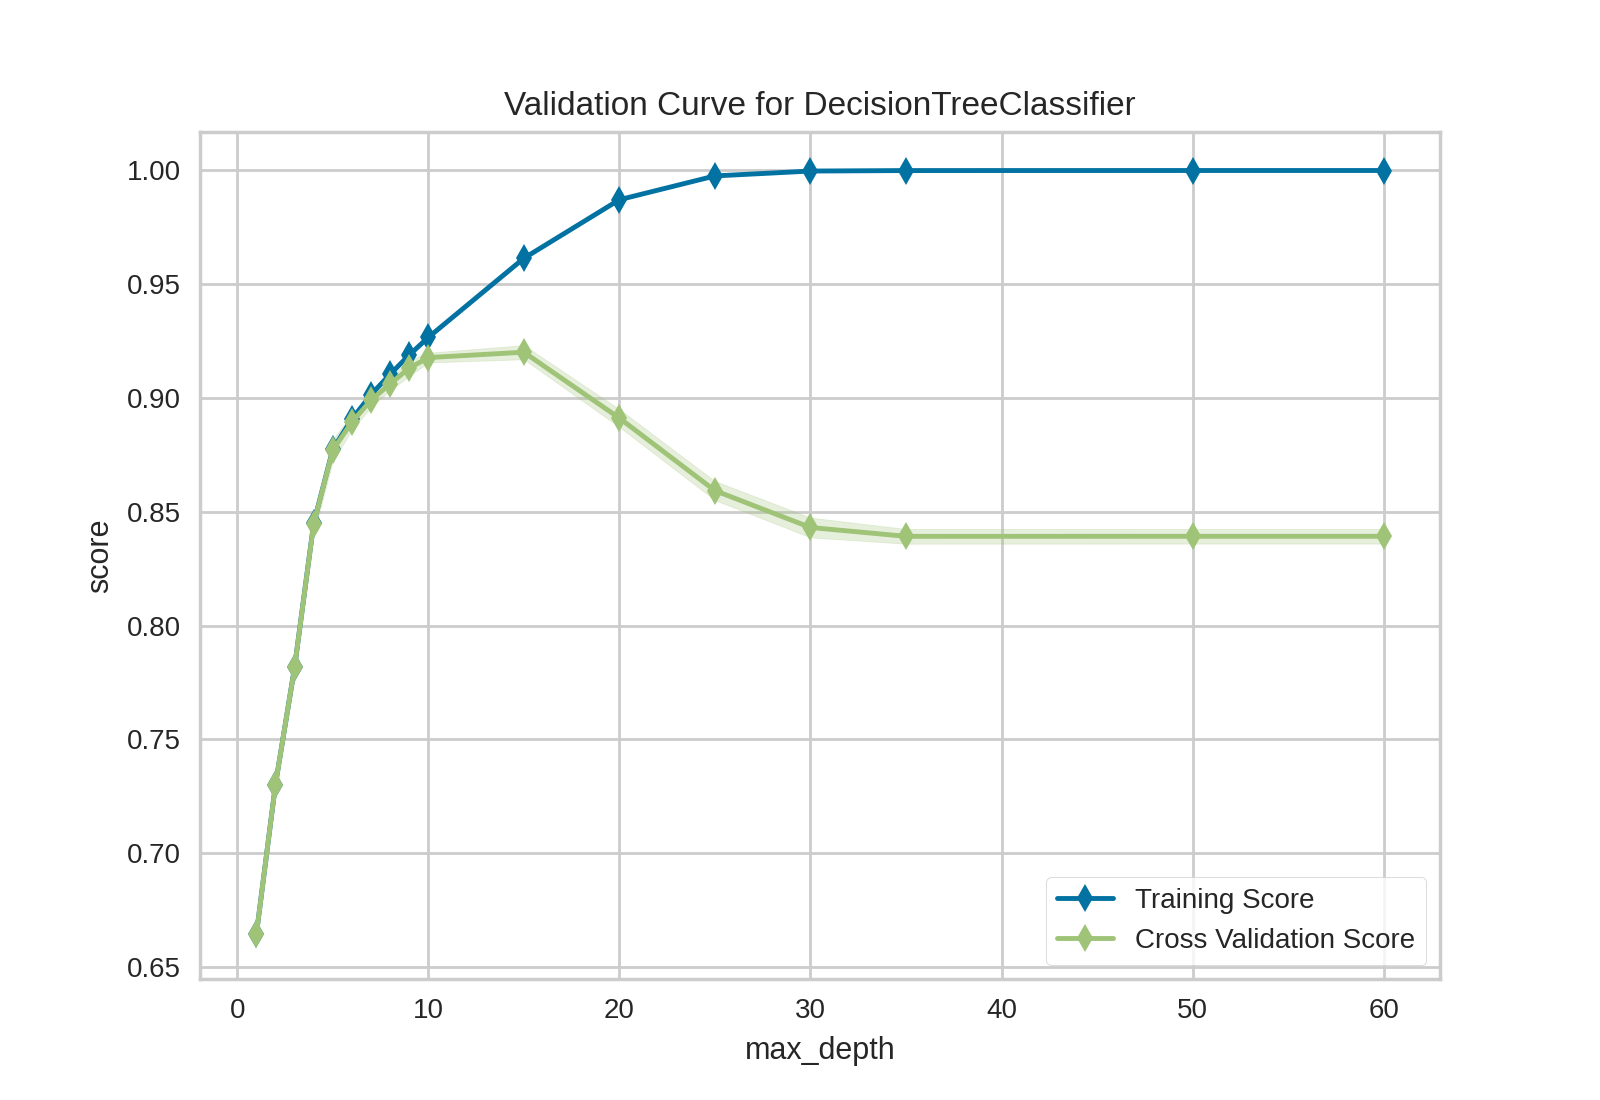

In [ ]:
def learning_curve(X_Train,Y_Train,X_Val,Y_Val,model,param_name,param_values):
    '''
    Descripción:
        Función encargada de generar una curva de aprendizaje sobre set de entrenamiento y validación de acuerdo con parámetros ingresados por el usuario

    Inputs
        * X_Train: Set de entrenamiento variables independientes
        * Y_Train: Set de entrenamiento variables dependientes
        * X_Val: Set de validación variables independientes
        * Y_Val: Set de validación variables dependientes
        * model: Modelo sobre el cual se genera la curva de aprendizaje
        * param_name: nombre del parámetros a modificar
        * param_values: Lista de los valores a evaluar en el parámetro

    Returns
        None

    '''
    #******************************* Visualizador para validación cruzada en set de entrenamiento
    val_vis=ValidationCurve(
        model,
        param_name=param_name,
        param_range= param_values,
        cv=10,
        n_jobs=-1,
        scoring="roc_auc"
    )
    val_vis.fit(X_Train,Y_Train)
    val_vis.show()

#****************************************************** Se genera un nuevo modelo de árbol de decisión y se valida curva sobre parámetro max_depth
dtc=DecisionTreeClassifier(random_state=seed,class_weight="balanced")
param_name="max_depth"
param_values=[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,50,60]
learning_curve(X_Train_prep,Y_Train,X_Val_prep,Y_Validation,dtc,param_name,param_values)



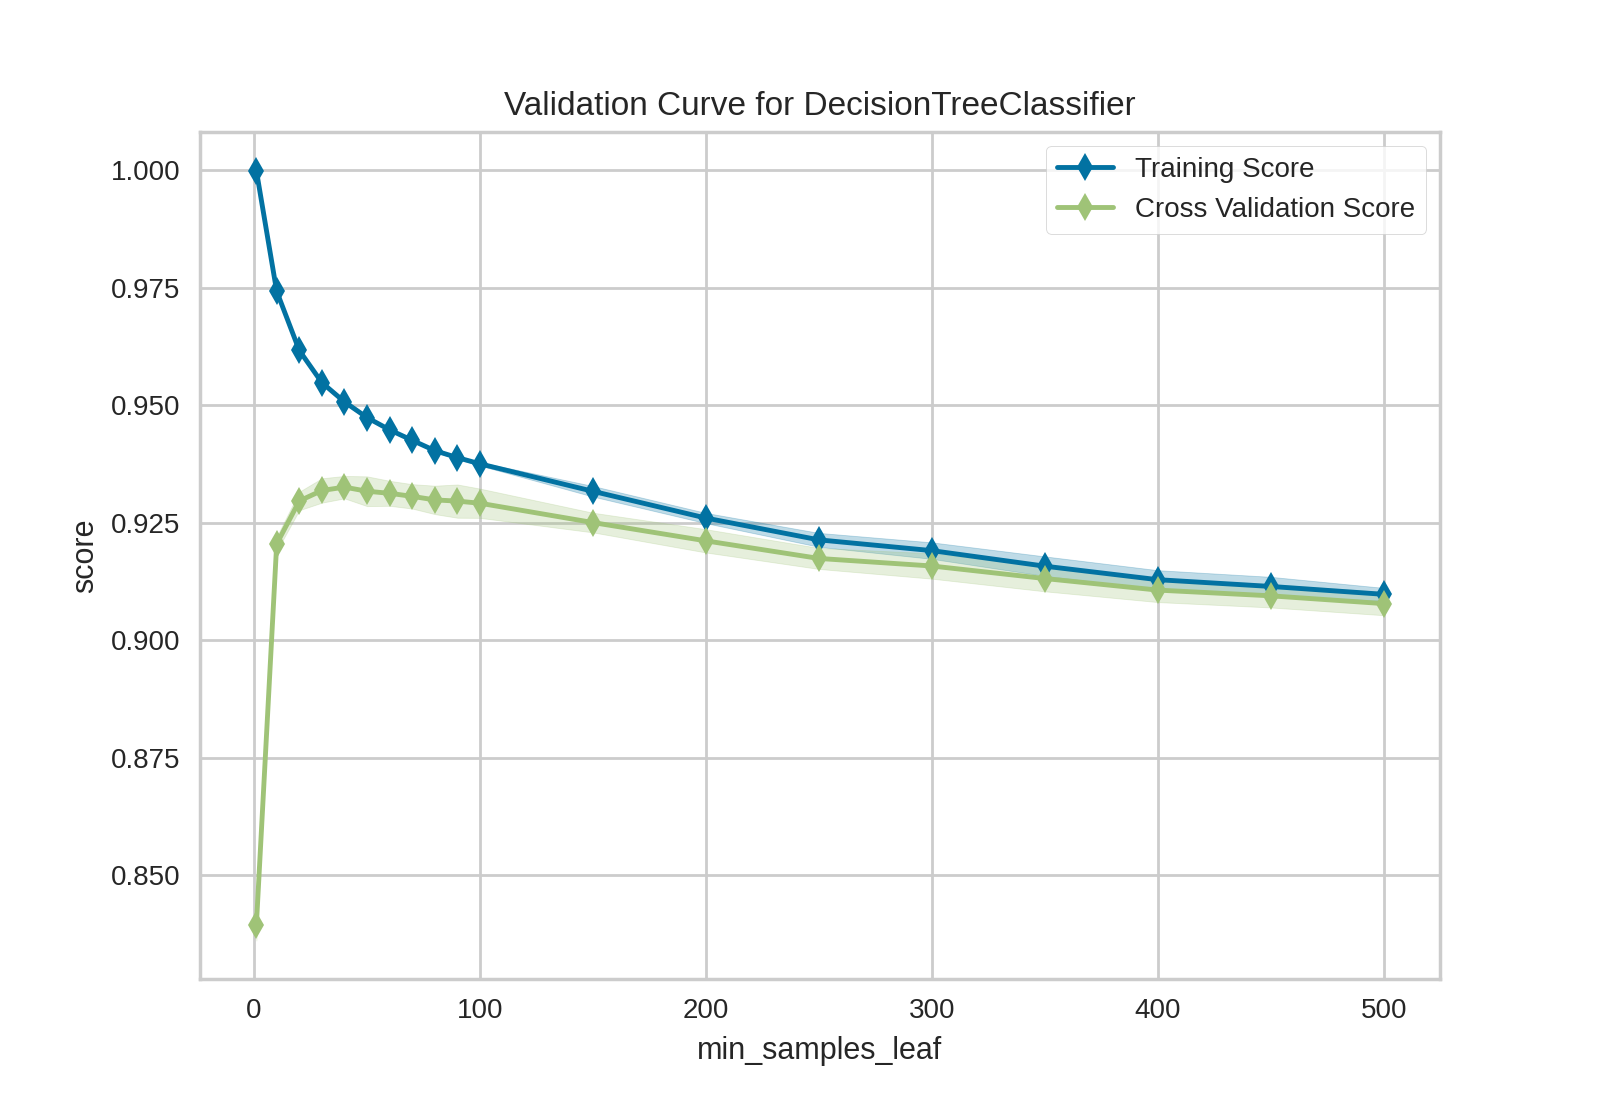

In [ ]:
#***************************** Curva de aprendizaje sobre min_samples_leaf
param_name="min_samples_leaf"
param_values=[1,10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500]
learning_curve(X_Train_prep,Y_Train,X_Val_prep,Y_Validation,dtc,param_name,param_values)


### Resultados Cross Validation

A continuación se presentan los resultados ROC para el modelo seleccionado de la búsqueda de hiperparámetros. Puntualmente, se identifica un scoring aceptable para el conjunto de validación usado para validar la búsqueda de hiperparámetros. También se obseva un resultado equivalente entre el scoring de validación y el de prueba.

de la validación cruzada para la selección del mejor algoritmo. Se presentan únicamente los primeros 10 rankeados.

In [ ]:
#********************************************************************** Definición de funciones **************************************************************
def tabla_gridcv(df):
    '''
     Descripción:
         Función encargada de generar un dataframe ordenado con información ordenada de los resultados de gridsearch de hiperparámetros
     Inputs:
         * df: DataFrame con todos los resultados almacenados de la búsqueda grid.
     Returns:
         * df_results: Dataframe con los resultados principales almacenados, junto con los hiperparámetros de las combinaciones
    '''

    # Se concatenan todos las combinaciones de la búsqueda grid search en el dataframe de resultados.
    pd_results=pd.concat([df.params.apply(pd.Series),df[["mean_test_score","mean_train_score","rank_test_score"]]],axis=1)
    pd_results[["mean_test_score","mean_train_score"]]=(pd_results[["mean_test_score","mean_train_score"]])
    pd_results.sort_values(by="rank_test_score",ascending=True,inplace=True)
    return pd_results

#**************************************************************************************************************************************************************

#***************************** Se realiza un grid search cv de acuerdo con los resultados obtenidos se realiza un grid search
params={"max_depth":[5,6,7,8,9,10],"min_samples_leaf":[50,60,70,80,90,100,110,120,130,140,150]} #Se define el diccionario de parámetros

dlt_grid=GridSearchCV( #Se realiza la búsqueda del mejor modelo con grid search
    dtc,
    param_grid=params,
    cv=10,
    return_train_score=True,
    n_jobs=-1
)
dlt_grid.fit(X_Train_prep,Y_Train) #Ajuste sobre el set de entrenamiento

#******************************* Impresión de resultados
print("\n Los parámetros del mejor modelo fueron: ", dlt_grid.best_params_)
best_model=dlt_grid.best_estimator_ #Se almacena el mejor modelo
score_model(X_Train_prep,Y_Train,X_Val_prep,Y_Validation,X_Test_prep,Y_Test,best_model) #Se imprimen los nuevos errores sobre los sets para verificar el resultado de la búsqueda

#Se imprime la tabla de resultados de la validación cruzada
cmap=sns.diverging_palette(250,5, as_cmap=True)   # Definición del estilo
grid_results=pd.DataFrame(dlt_grid.cv_results_) # Se almacenan los resultados de la búsqueda
pd_comparation=tabla_gridcv(grid_results)         # Se almacenan los resultados puros del cross validation en una tabla
pd_comparation.head(10).style.background_gradient(axis=0,cmap=cmap,subset=['mean_train_score', 'mean_test_score']) # Se pone el estilo sobre la tabla de resultados.


 Los parámetros del mejor modelo fueron:  {'max_depth': 10, 'min_samples_leaf': 150}

 Error promedio de validación cruzada sobre el set de entrenamiento:  0.92

 Error sobre set de validación  0.82

 Error sobre set de Prueba  0.82


,max_depth,min_samples_leaf,mean_test_score,mean_train_score,rank_test_score
65,10,150,0.823637,0.826379,1
64,10,140,0.822414,0.825174,2
59,10,90,0.822364,0.826166,3
60,10,100,0.822163,0.826006,4
58,10,80,0.821694,0.826775,5
53,9,140,0.821258,0.824115,6
48,9,90,0.821241,0.824594,7
61,10,110,0.821191,0.824804,8
63,10,130,0.821174,0.824534,9
56,10,60,0.820990,0.826352,10


### Recursive feature elimination

Se ejecuta un recursive feature elimination usando yellowbrick, obteniendo que se pueden mantener el mismo roc-auc score, con un número mucho menor de variables de independientes. Se opta por manejar este nuevo modelo ya que es más simple.

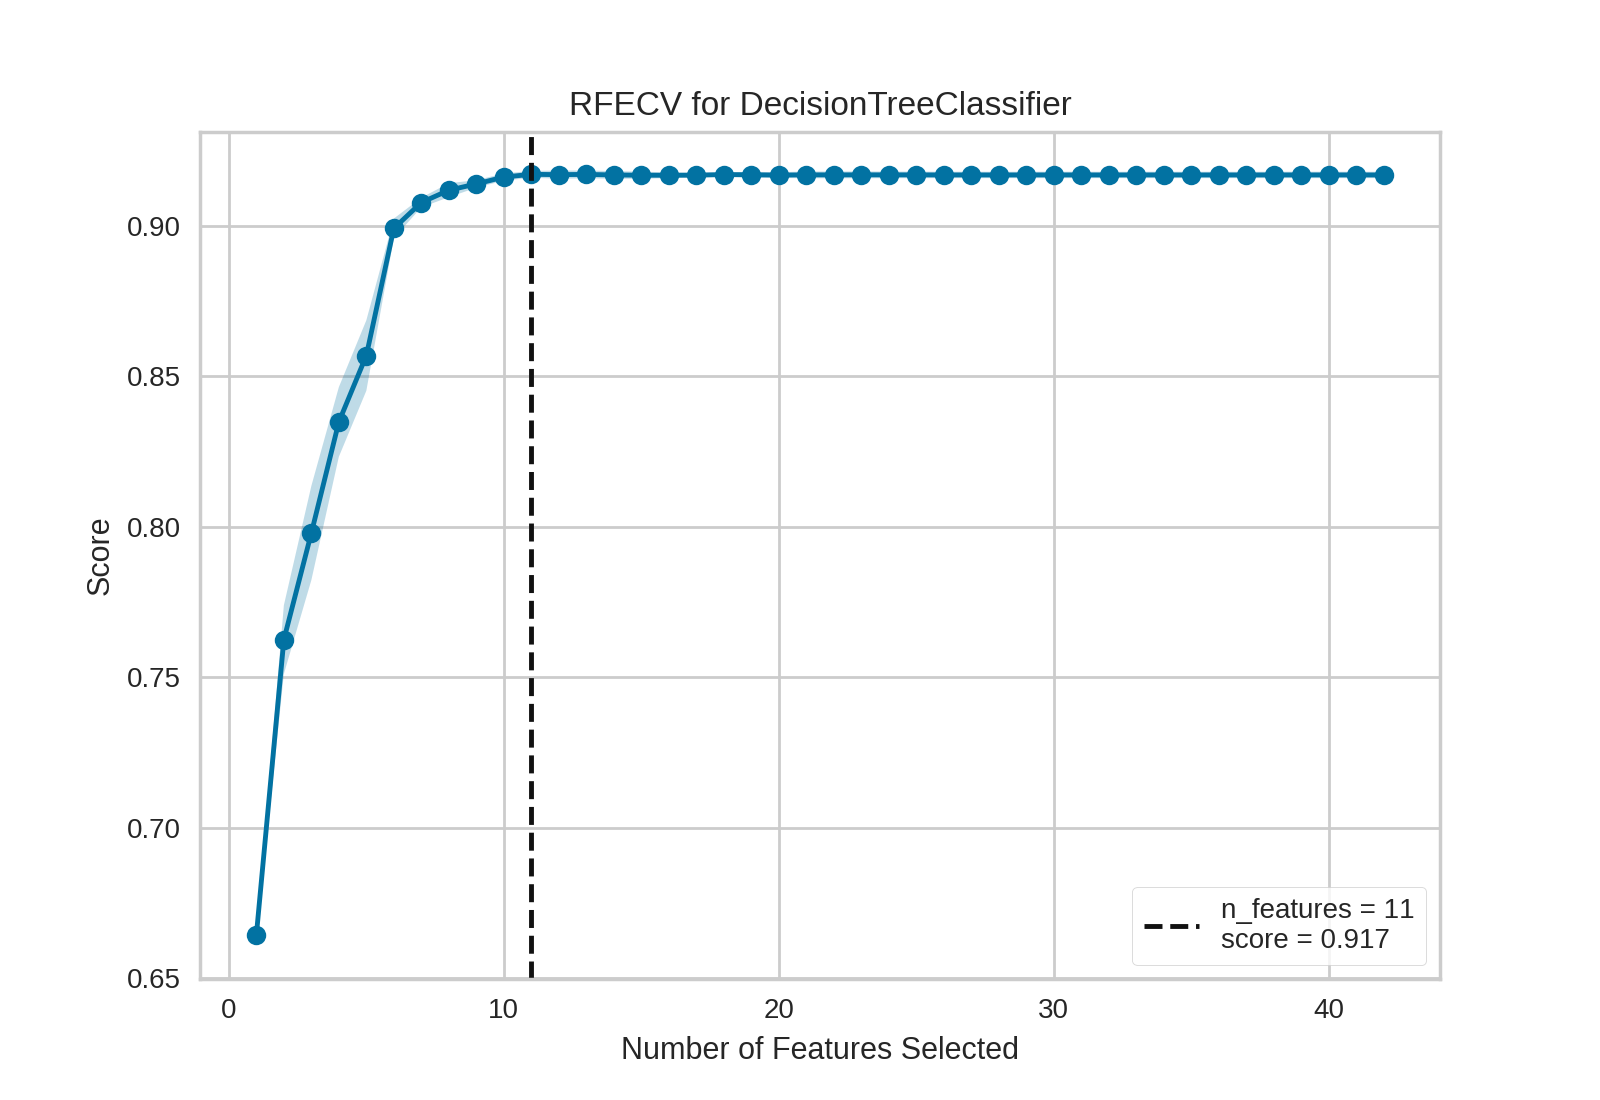


 Las variables seleccionadas fueron:  Index(['lead_time', 'arrival_date_year', 'previous_cancellations',
       'booking_changes', 'required_car_parking_spaces',
       'total_of_special_requests', 'Class__Online TA', 'Class__Non Refund',
       'Class__Transient', 'Class__PRT', 'agent'],
      dtype='object')

 Las variables eliminadas:  Index(['arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'previous_bookings_not_canceled', 'days_in_waiting_list',
       'adr', 'Class__City Hotel', 'Class__Resort Hotel', 'Class__Aviation',
       'Class__Complementary', 'Class__Corporate', 'Class__Direct',
       'Class__Groups', 'Class__Offline TA/TO', 'Class__No Deposit',
       'Class__Refundable', 'Class__Contract', 'Class__Group',
       'Class__Transient-Party', 'Class__ESP', 'Class__FRA', 'Class__GBR',
       'Class__Other', 'reserved_room_type', 'arrival_date_month',
       'assigned_roo

In [ ]:
#********************************************************************** Definición de funciones **************************************************************
def RFE(X_Train,Y_Train,X_Valid,Y_Valid,X_Test,Y_Test,model):
    '''
    Description
        Función encarga de graficar un recursive feature elimination a partir de un modelo sobre un set de variables X_data Y_data

    Inputs:
        * X_Train: Información de entrada variable independiente - entrenamiento
        * Y_Train: Información de entrada variable dependiente - entrenamiento
        * X_Valid: Información de entrada variable independiente - entrenamiento
        * Y_Valid: Información de entrada variable dependiente - entrenamiento

        * model: Modelo PREVIAMENTE ajustado sobre set de datos

    Return:
        * selected_vars:          Variables seleccionadas después del recursive feature elimination
        * X_Train_Recursive_data: Set de entrenamiento variables independientes filtradas de acuerdo con el resultado de la eliminación recursiva
        * X_Valid_Recursive_data: Set de validación variables independientes filtradas de acuerdo con el resultado de la eliminación recursiva
        * X_Test_Recursive_data:  Set de prueba variables independientes filtradas de acuerdo con el resultado de la eliminación recursiva
        * recursive_model:        Modelo generado y ajustado sobre el set de variables

    '''
    #**************************************** Se genera el visualizador con coring roc_auc
    vis_RFE=RFECV(
        model,
        scoring="roc_auc",
        cv=5,
            )
    vis_RFE.fit(X_Train,Y_Train)
    vis_RFE.show()

    #**************************************** Se toman las características obtenidas de la eliminación recursiva
    selected_vars=vis_RFE.support_
    print("\n Las variables seleccionadas fueron: ", X_Train.columns[selected_vars])
    print("\n Las variables eliminadas: ",X_Train.columns[~selected_vars])

    #**************************************** Filtrado de variables seleccionadas
    var_columns=X_Train.columns[selected_vars] #Se toman las columnas elegidas del recursive feature elimination
    X_Train_Recursive_data=X_Train[var_columns].copy() #Se genera una copia de las variables seleccionadas - entrenamiento
    X_Valid_Recursive_data=X_Valid[var_columns].copy() #Se genera una copia de las variables seleccionadas - validación
    X_Test_Recursive_data=X_Test[var_columns].copy() #Se genera una copia de las variables seleccionadas - Prueba

    recursive_model=clone(model) #Se genera una copia del modelo de input

#****************************************Se ajusta el nuevo modelo sobre la data de entrenamiento y se obtienen las métricas de puntaje
    recursive_model.fit(X_Train_Recursive_data,Y_Train)

    score_model(X_Train_Recursive_data,Y_Train,X_Valid_Recursive_data,Y_Validation,X_Test_Recursive_data,Y_Test,recursive_model) # Function Call -> Se imprimen los nuevos errores sobre los sets para verificar el resultado de la eliminación recursiva

    return selected_vars, X_Train_Recursive_data, X_Valid_Recursive_data, X_Test_Recursive_data, recursive_model


#*****************************************************************************************************************************************************************************

[selected_vars, X_Train_Recursive_data, X_Valid_Recursive_data, X_Test_Recursive_data, recursive_model]= RFE(X_Train_prep,Y_Train,X_Val_prep,Y_Validation,X_Test_prep,Y_Test,best_model) #Se realiza el proceso de eliminación recursiva sobre las variables, para verificar si esto puede llevar a mejores resultados



### Estudio de threshold

Tras estudiar la gráfica de Discrimination Threshold, y Recall vs precision, no se evidencia un posible tradeoff que sea muy significativo entre recall y precision que amerite cambiar el threshold de clasificación.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


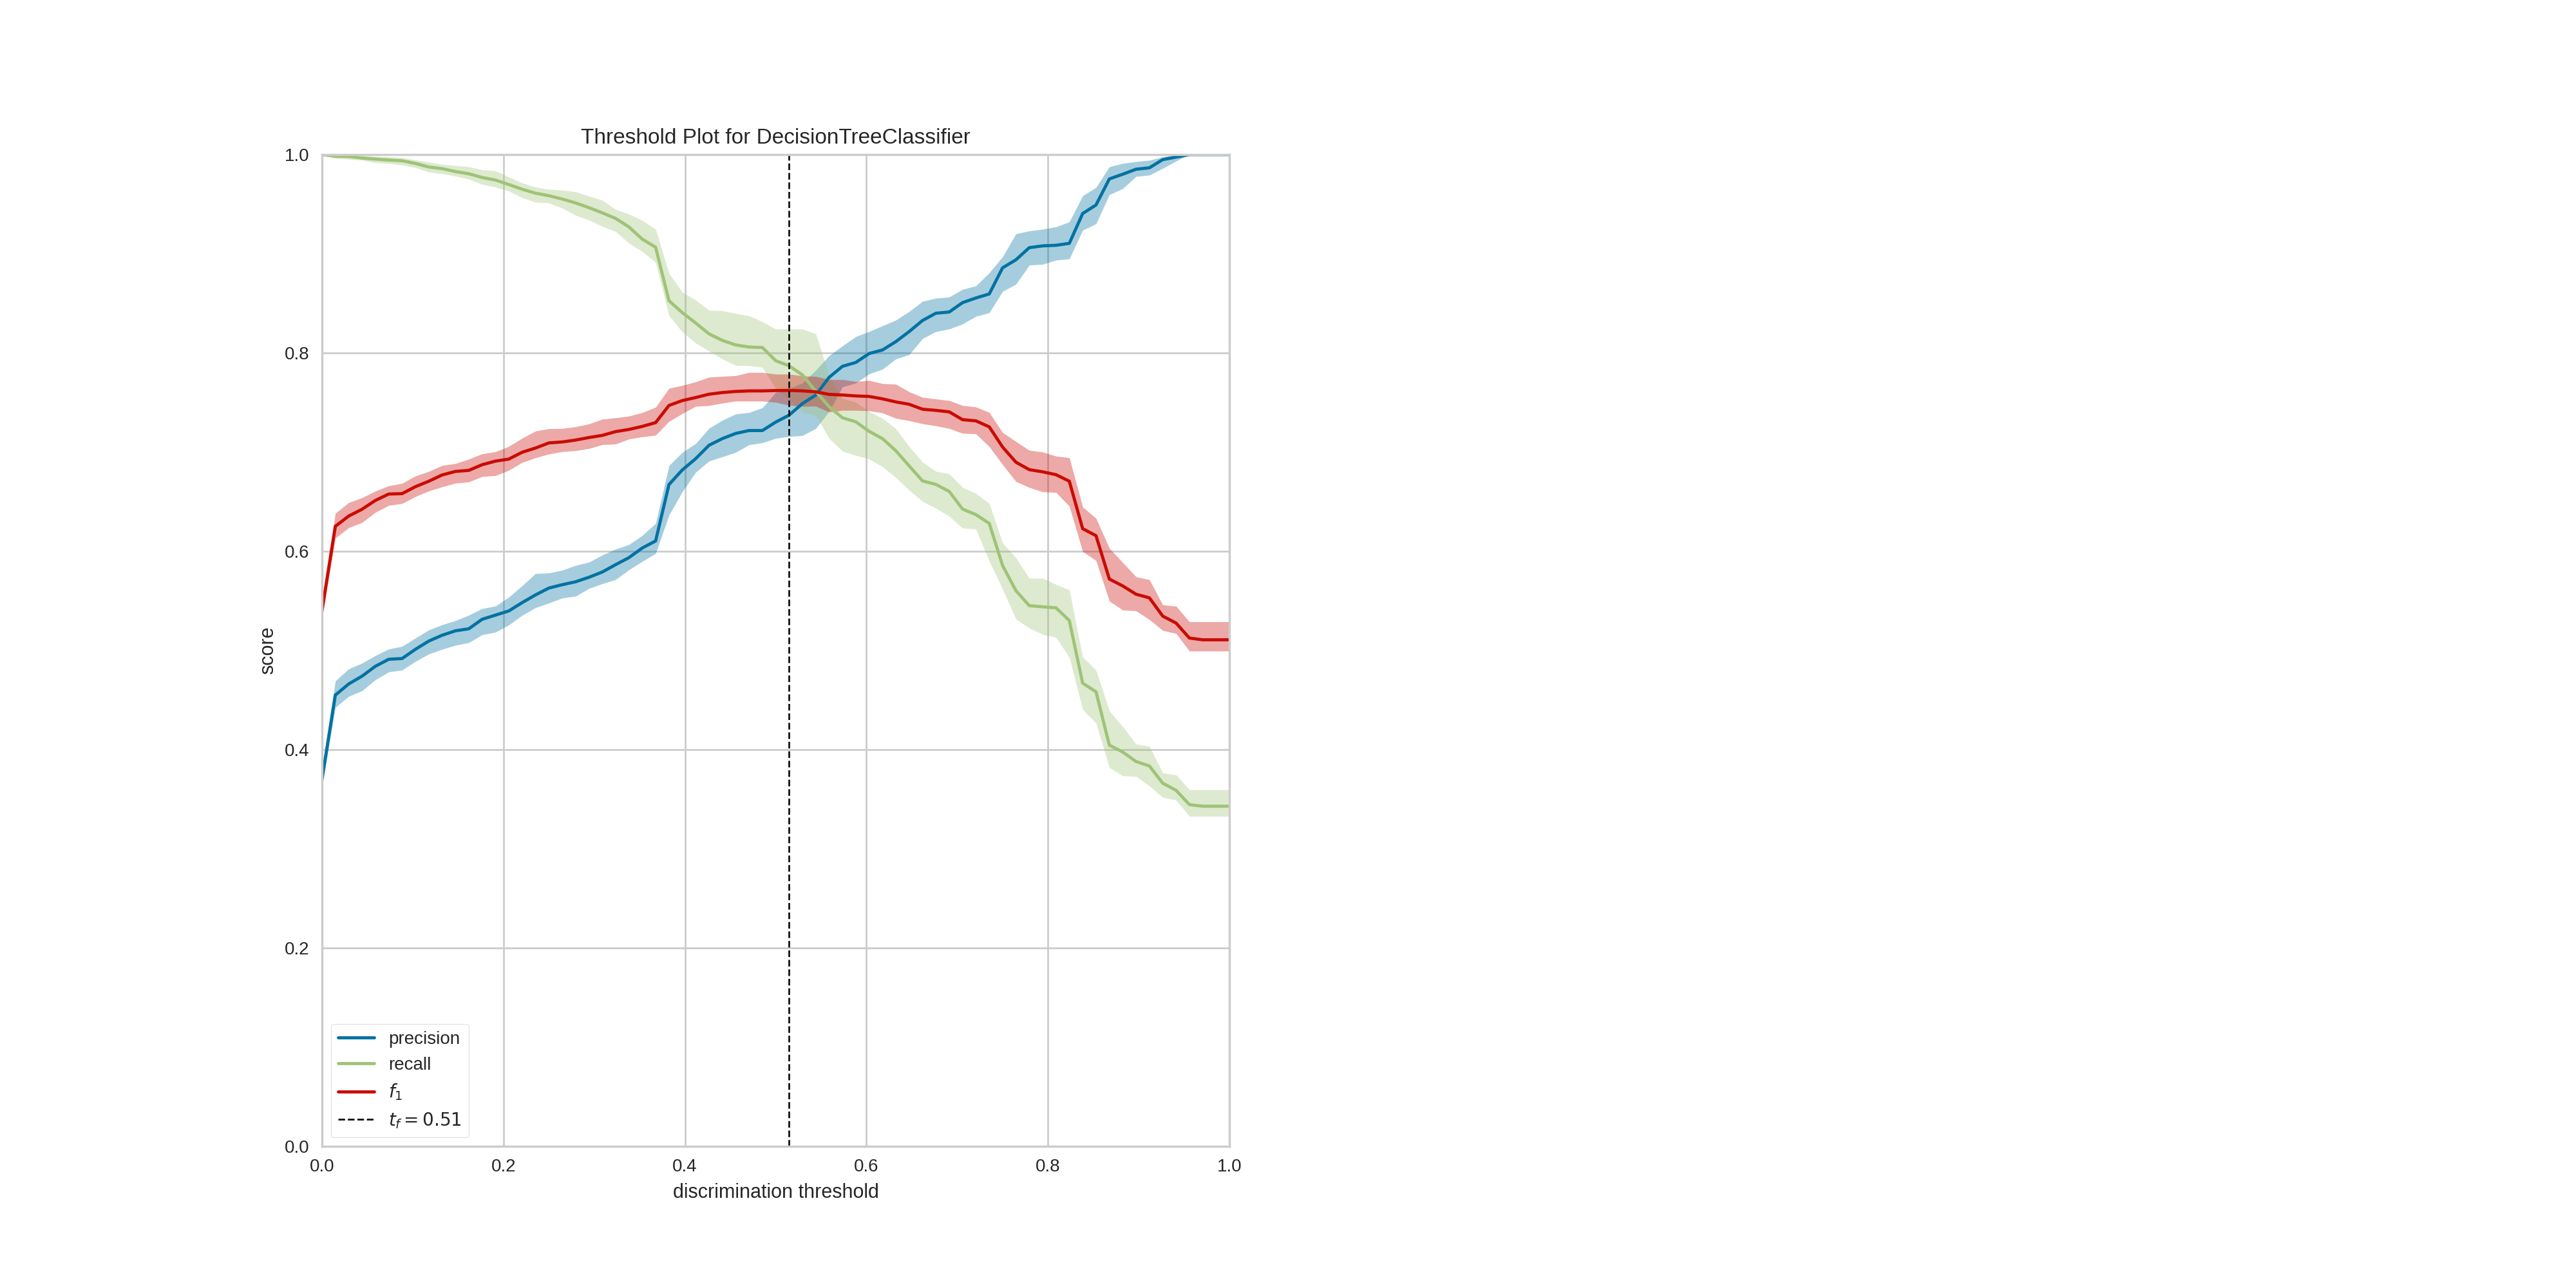

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


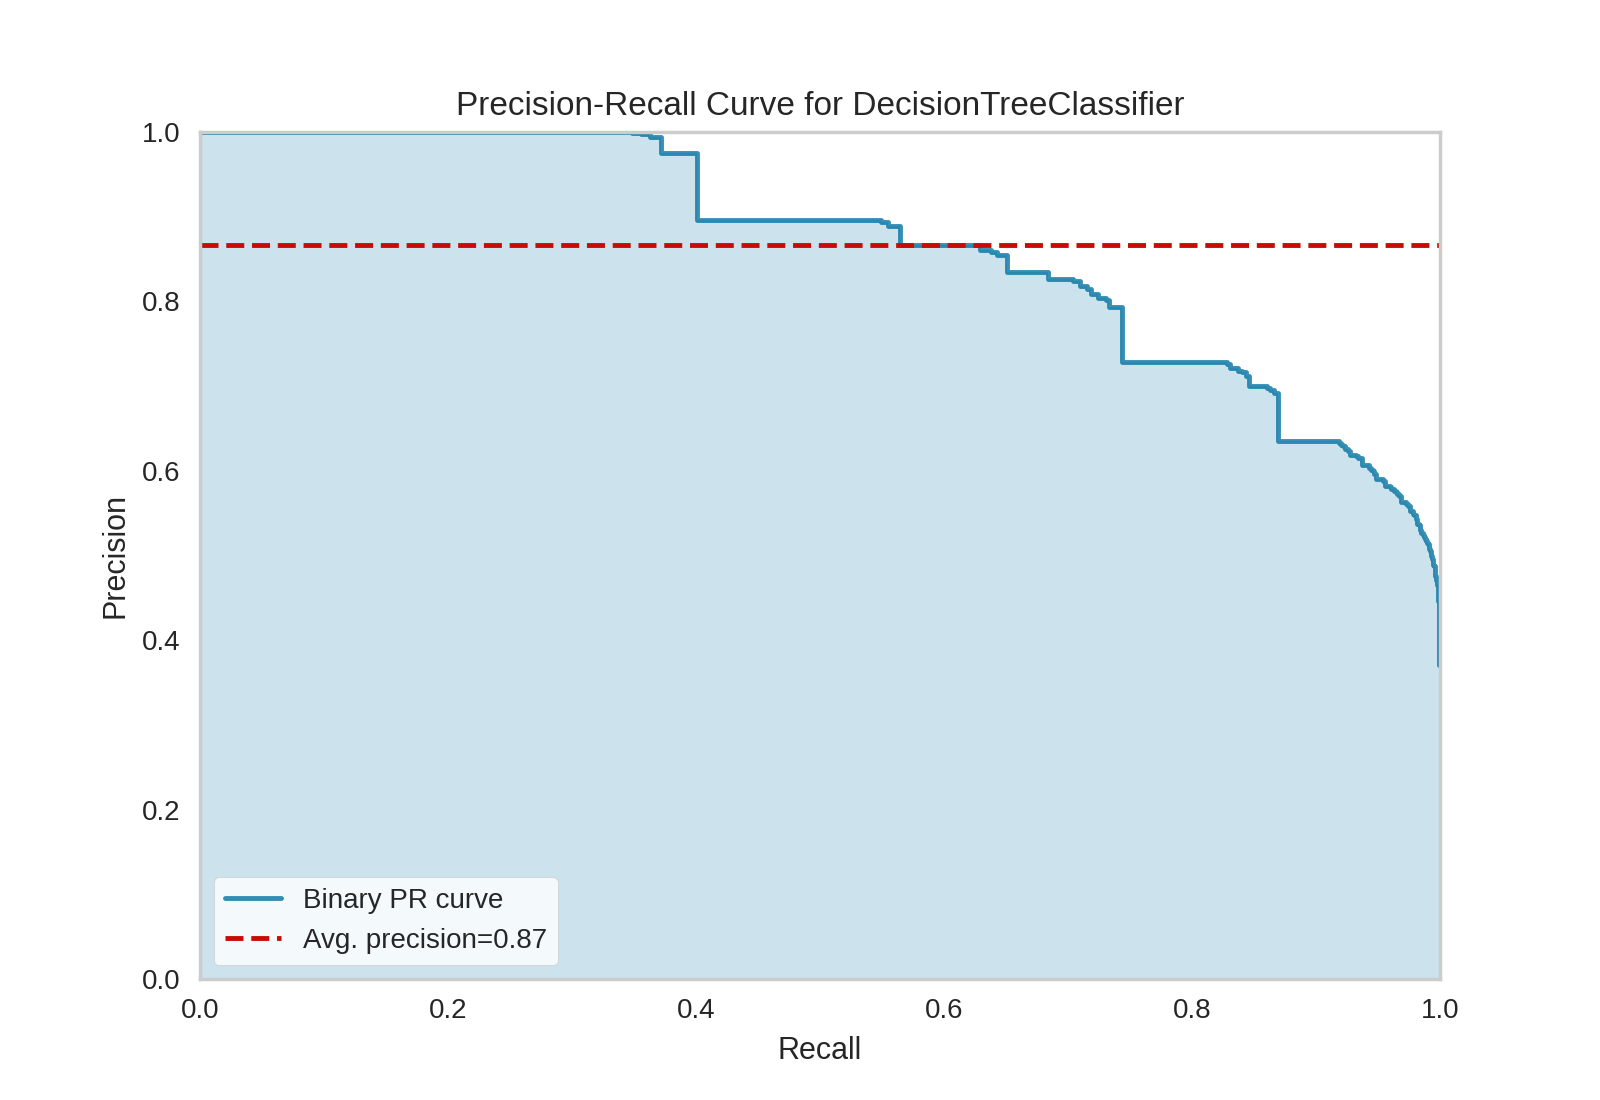

In [ ]:
#********************************************************************** Definición de funciones **************************************************************
def threshold_graf(X_Train,Y_Train,X_Valid,Y_Valid,model):
    '''
    Descripción:
        Función encargada de
        * generar el Discrimination Threshold de un modelo sobre un set de validación
        * generar la curva precision vs recall sobre set de validación
        El modelo debe estar previamente entrenado sobre un set de entranamiento

    Inputs:
        * X_Valid: Conjunto de variables independientes set de validación
        * Y_Valid: Conjunto de variables dependientes set de validación

    Returns
        None

    '''
    #********************************** Creación y ajuste del visualizador

    figure=plt.figure(figsize=(20,10))

    figure.add_subplot(121)
    vis_thresh=DiscriminationThreshold( #Se crea el visualizador para curva del discrimination Threshold
            model,
            exclude=["queue_rate"]
    )
    vis_thresh.fit(X_Valid,Y_Valid) #Se ajusta sobre set de validación
    vis_thresh.show()

    figure.add_subplot(122)
    vis_pvsr=PrecisionRecallCurve(model)
    vis_pvsr.fit(X_Train,Y_Train) #Ajustamos sobre set de entrenamiento
    vis_pvsr.score(X_Valid,Y_Valid) #score sobre set de validación
    vis_pvsr.show()


#*****************************************************************************************************************************************************************************

#**************************** Se verifica la curva de discriminación de threshold sobre el set de validación.
threshold_graf(X_Train_Recursive_data,Y_Train,X_Valid_Recursive_data,Y_Validation,recursive_model)


#5) Evaluar e interpretar los resultados del mejor modelo en el conjunto de prueba

Tienes que reportar un modelo con un F1-score superior e interpretar los siguientes resultados. (Recuerda que obtener un F1 score más alto, implica reducir el error de generalización)
Reporta el error de clasificación F1.
Grafica e interpreta la matriz de confusión.
Grafica e interpreta reporte de clasificación de precisión, recall y F1 score.
Grafica e interpreta la curva ROC y el AUC score.

#Conclusiones del punto

Con el nuevo modelo propuesto se consigue mejorar el F1-Score de la clase que no canceló de 0.71 a 0.85. Por otro lado, el F1-Score de la clase que canceló mejoró 0.69 a 0.77.

* En la clase que No canceló, disminuyó la precisión en 0.03, pero se consiguió un aumento de 0.34 en el recall

* En la clase que Canceló, aumentó la precisión en 0.27, pero disminuyó un 0.09 el recall.

* En la curva ROC-AUC se evidencia un aumento en el tamaño del área, con respecto a la misma curva del modelo inicial. Además ya no se presenta la relación lineal del modelo, y sería posible mantener un recall de aproximadamente 82% sobre la clase que Canceló, manteniendo la tasa de errores en la clase por debajo del 20%

En general, el tradeoff en los indicadores de calidad muestra una mejoría en el modelo.



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


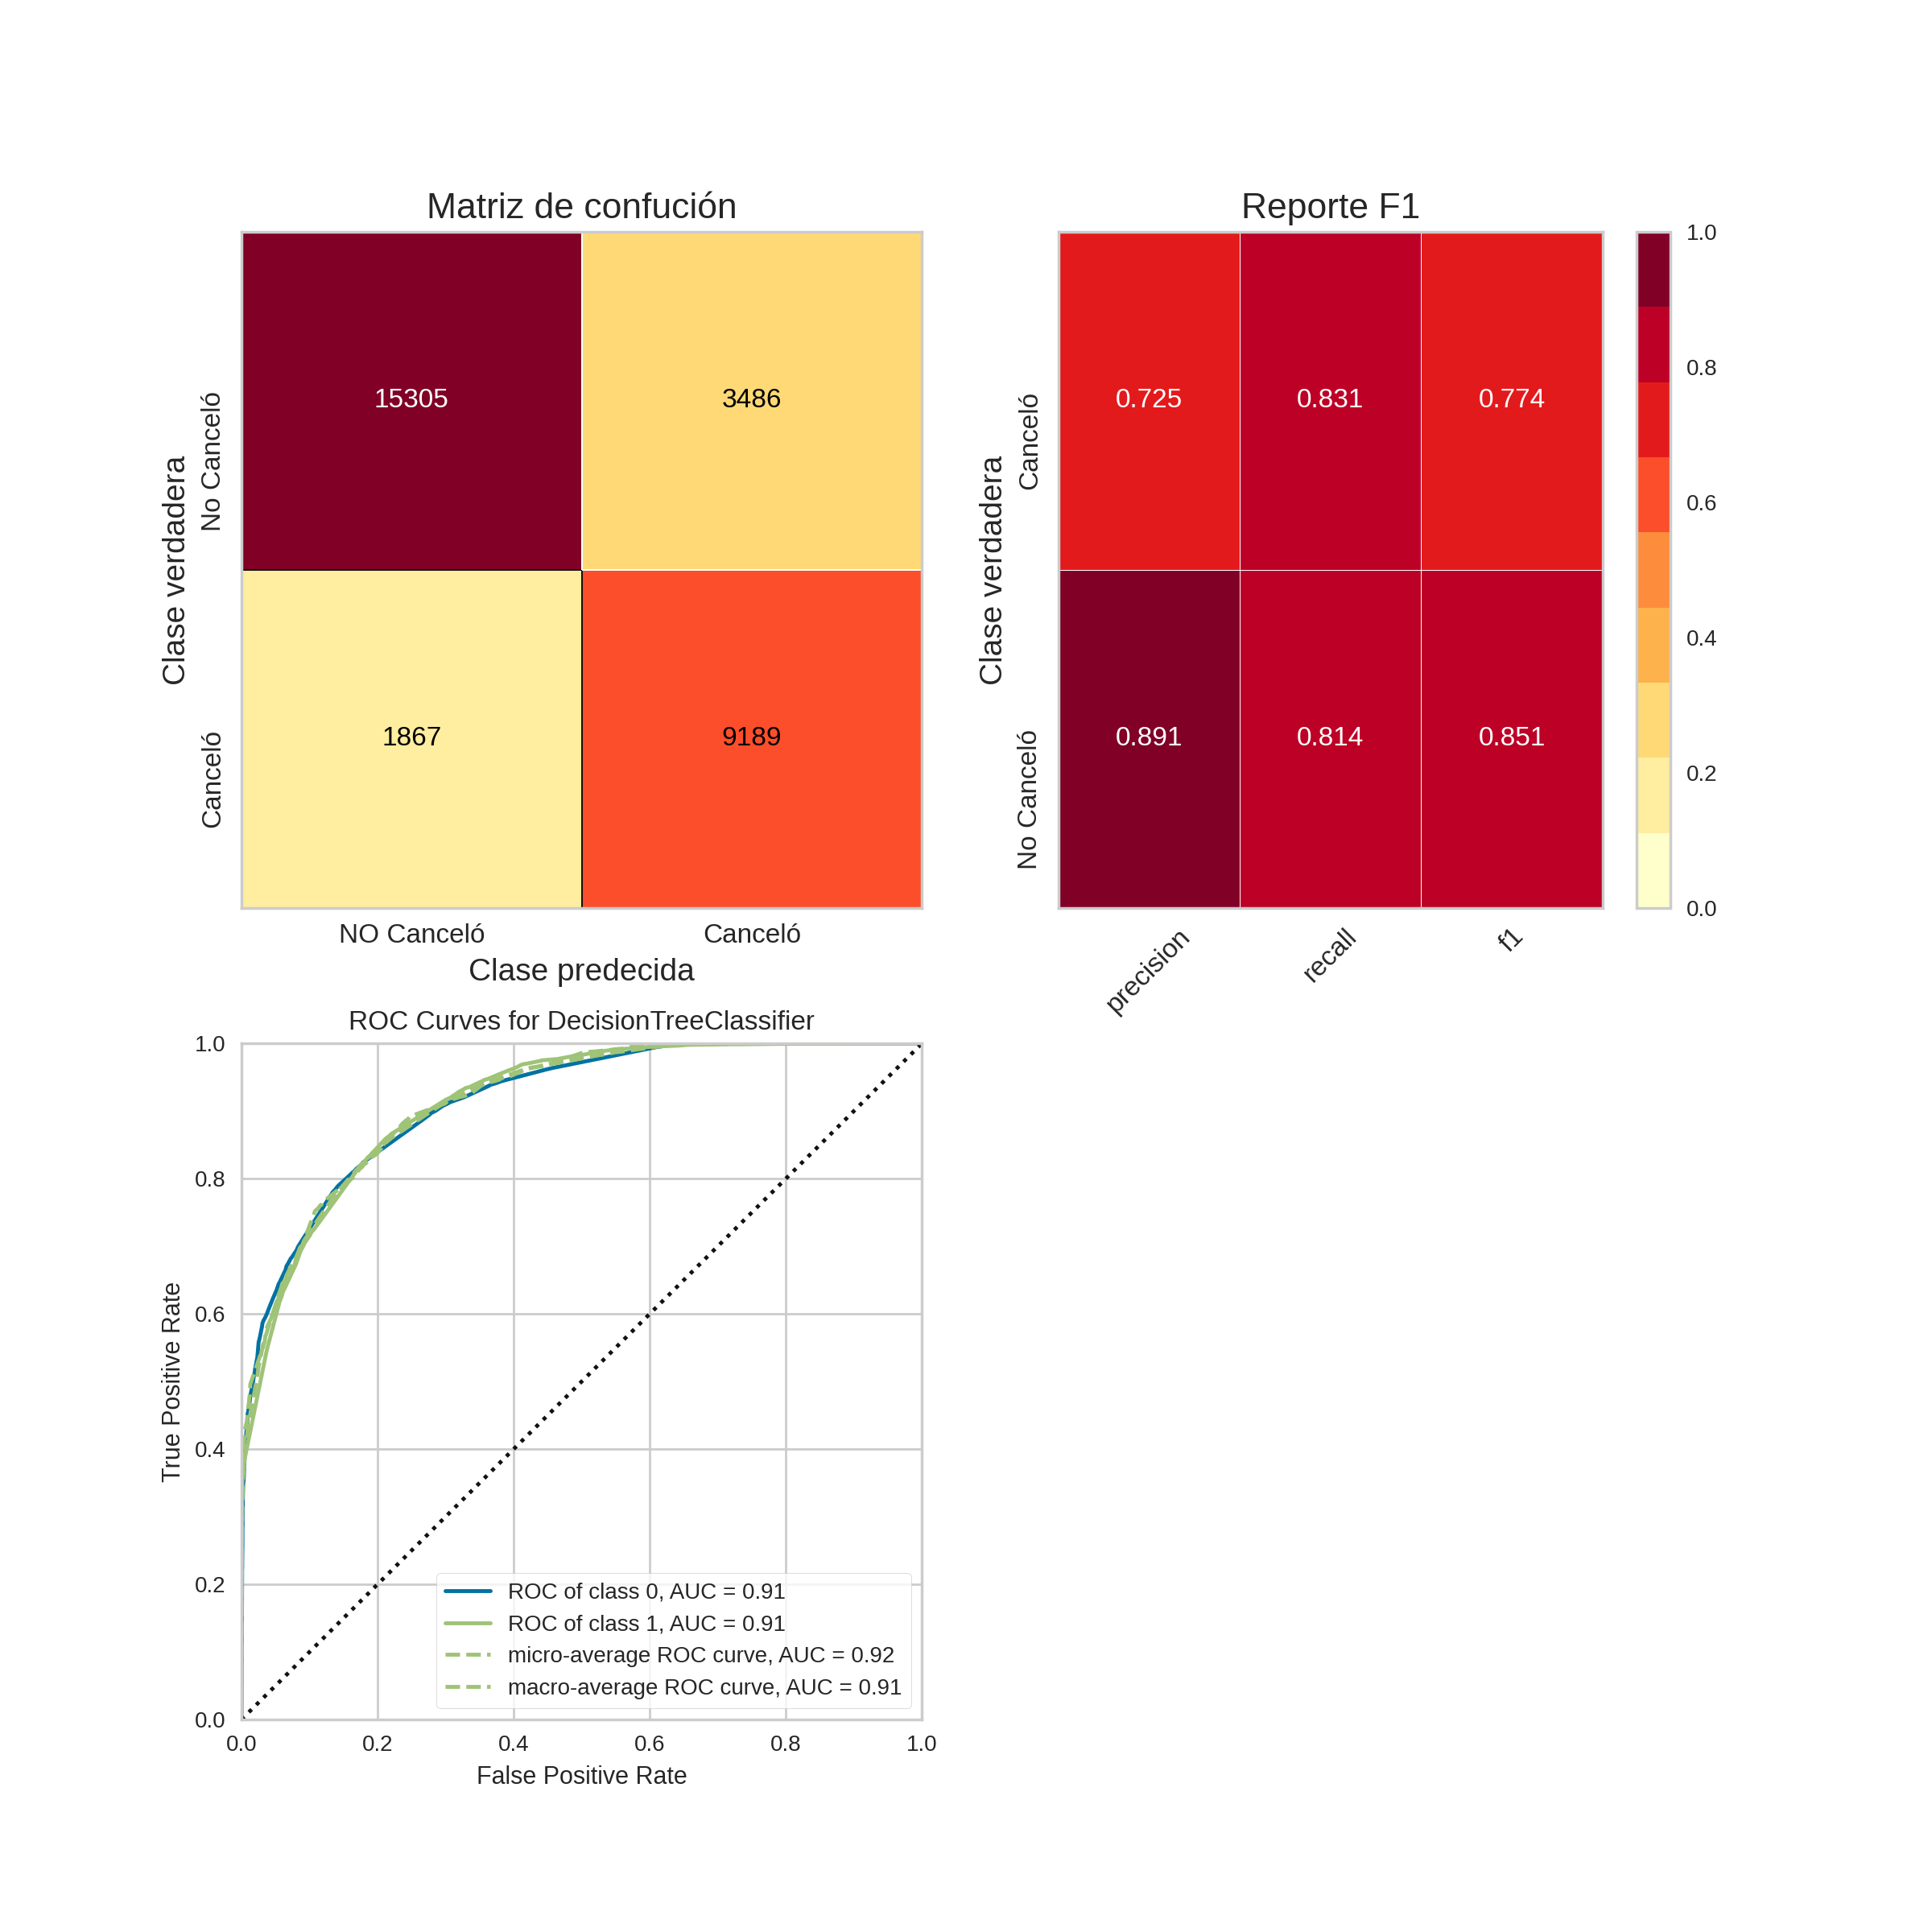

<Figure size 800x550 with 0 Axes>

In [ ]:
#****************************************** Impresión de reporte f1 de calidad para el nuevo modelo y curva ROC-AUC

Confussion_f1_rocauc(X_Train_Recursive_data,Y_Train,X_Test_Recursive_data,Y_Test,recursive_model)


#6) Genera un CSV

Genera un CSV con todos los datos de reservaciones que incluya solo tres columnas el id de la reservación, la probabilidad de cancelación y la clasificación de cancelación (0 ó 1), que Juan le va a entregar a Belén.

#Conclusiones del punto

Se genera el CSV solicitado sobre el set de prueba. Se asume que el Id de la reserva coincide con el




In [ ]:
prediction=recursive_model.predict(X_Test_Recursive_data) # Se realiza la predicción sobre el set de prueba
prediction_prob=np.round(recursive_model.predict_proba(X_Test_Recursive_data),2)[:,1] #Se pronostica la probabilidad

#Ofrezco disculpas por las tildes, pero no logro que imprima los caracteres de forma correcta.
results_DF=pd.DataFrame({"Prediccion":prediction,"Probabilidad cancelacion":prediction_prob}) #Se crea el dataframe con las predicciones y probabilidades concatenadas

results_DF.reset_index(inplace=True,drop=False) #Se convierte el index a columna para tratarlo como ID de cliente
results_DF.rename(columns={"index":"ID-cliente"},inplace=True) #Se renombra la columna

results_DF.to_csv("Model_Results.csv",index=False) #Finalmente se imprime el csv solicitado





#7) Justifica tus decisiones e interpretar los resultados

Cómo tu modelo y tus entregables ayudarán al negocio a evitar que los clientes de la cadena hotelera cancelen sus reservaciones.

#Conclusiones del modelo

Se ha elaborado un modelo de machine learning con el objetivo de predecir cuándo un cliente cancelará su reserva de hotel. Es un modelo del tipo "árbol de decisión" que ha sido optimizado en su elaboración para mejorar la calidad de la predicción.

La calidad del modelo fue evaluada mediante varias métricas, obteniendo los siguientes resultados generales sobre una población de prueba de zzz clientes:

* El modelo es capaz de identificar correctamente con un xx% de confiabilidad cuándo un cliente SI Cancelará una reserva, y se espera que un yy% de las predicciones de cancelación del modelo sean correctas.

* El modelo es capaz de identificar correctamente con un xx% de confiabilidad cuándo un cliente No Cancelará una reserva, y se espera que un yy% de las predicciones de cancelación del modelo sean correctas.

* Se evaluó la calidad del modelo mediante la métrica ROC-AUC, obteniendo un resultado de 0.82. Este resultado indica que el modelo tiene una eficacia del 82% a la hora de distinguir los clientes que cancelarían su reserva de aquellos que no lo harían.

* Para complementar la evaluación de calidad se usó también el indicador F1, que es una medida armonizada entre la exactitud, y la precisión del modelo. Este indicador mostró a un resultado de 0.77 a la hora de predecir los clientes que cancelarían su reserva, y un 0.87 a la hora de predecir aquellos que no lo harían.

Para terminar, se presentan los resultados obtenidos sobre el set de prueba, donde se indica el ID de la reservación, el pronóstico del modelo sobre si el cliente cancelará o no su reserva, y la probabilidad de cancelación.
